# Neutrino event classification

This mini-project is about classifying neutrino events on data reminiscent of the NOvA experiment. This notebook consists of three parts -- the data preparation, development of various neural networks, and discussion of the results. For more background information and in-depth descriptions -- see the report.

This notebook directly corresponds to the respective sections of the report.
- Data (2.1 in the report)
- Training and testing (2.1)
- Noise (3.3.3)
- Psihas classifier (3.1)
- $\nu_{\mu}$-classifier (3.2)
- More convolution and/or dense layers, noise, more dropouts (3.3)
- Final state classifier (3.4.1)
- Energy classifier (3.4.2)
- Analysis with respect to metadata (3.5)

# Data (2.1)

The dataset is comprised of a number of files containing images of simulated neutrino interactions in a hypothetical detector similar to that in NOvA. For each neutrino interaction the images consist of two $100 \times 80$ pixel images that represent the $x \times z$ and $y \times z$ projections of the tracks of particles in the detector.

The data for this mini-project comes in the form of the following files:

| File | Description |
| ----------- | ----------- |
| neutrino1.h5 | The 1st HDF5 file containing event images and meta deta |
| $\vdots$ | The middle ones |
| neutrino200.h5| The 400th HDF5 file|


The images show the energy deposited by simulated neutrinos in a NOvA like detector. Some of the meta information in the hdf5 file is described below

| Label | Description |
| ----------- | ----------- |
| neutrino/nuenergy | Neutrino Energy (GeV) |
| neutrino/lepenergy | Lepton Energy (GeV) |
| neutrino/finalstate | Interaction |
| neutrino/finalstate | Final State |
 

The [PDG code](https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf) is a number which identifies the particle type (e.g electron=11, electron-neutrino=12, etc.)

The $interaction$ says what kind of interaction occured and is defined in the enumeration below.

The following shows how the data was imported and reshaped so it is easy to use.

## Package import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import h5py

import matplotlib.style #Stylistic package
import matplotlib as mpl #Stylistic package

import urllib.request
from sklearn.model_selection import train_test_split # useful for preparing the traning, testing, and validation datasets

#Set default figure size
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

#Useful for debugging problems
print(tf.__version__)

2.7.0


In [2]:
#The following is needed to build neural networks
import keras 
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.regularizers import l2
from keras.layers import BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras import models
from keras.models import Model
from keras.layers.merge import concatenate
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate

In [3]:
#Import of some statistical tools like confusion matrix
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

The following was supplied as a part of task

In [4]:
import enum # important to enumerate the metadata with types
class Interaction(enum.Enum):
    kNumuQE =0           # Numu CC QE interaction
    kNumuRes =1           # Numu CC Resonant interaction
    kNumuDIS = 2          # Numu CC DIS interaction
    kNumuOther = 3        # Numu CC, other than above
    kNueQE = 4            # Nue CC QE interaction
    kNueRes = 5           # Nue CC Resonant interaction
    kNueDIS = 6           # Nue CC DIS interaction
    kNueOther = 7         # Nue CC, other than above
    kNutauQE = 8          # Nutau CC QE interaction
    kNutauRes = 9         # Nutau CC Resonant interaction
    kNutauDIS =10         # Nutau CC DIS interaction
    kNutauOther =11       # Nutau CC, other than above
    kNuElectronElastic = 12# NC Nu On E Scattering
    kNC =13                # NC interaction
    kCosmic =14           # Cosmic ray background
    kOther =15            # Something else.  Tau?  Hopefully we don't use this
    kNIntType=16          # Number of interaction types, used like a vector size

    
class FinalState(enum.Enum):
    kNumu0tr0sh=0          # Numu CC - no track no shower
    kNumu0tr1sh=1          # Numu CC - no track  1 shower
    kNumu0tr2sh=enum.auto()          # Numu CC - no track  2 shower
    kNumu0trMsh=enum.auto()          # Numu CC - no track 3+ shower
    kNumu1tr0sh=enum.auto()          # Numu CC -  1 track no shower
    kNumu1tr1sh=enum.auto()          # Numu CC -  1 track  1 shower
    kNumu1tr2sh=enum.auto()          # Numu CC -  1 track  2 shower
    kNumu1trMsh=enum.auto()          # Numu CC -  1 track 3+ shower
    kNumu2tr0sh=enum.auto()          # Numu CC -  2 track no shower
    kNumu2tr1sh=enum.auto()          # Numu CC -  2 track  1 shower
    kNumu2tr2sh=enum.auto()          # Numu CC -  2 track  2 shower
    kNumu2trMsh=enum.auto()          # Numu CC -  2 track 3+ shower
    kNumuMtr0sh=enum.auto()          # Numu CC - 3+ track no showe
    kNumuMtr1sh=enum.auto()          # Numu CC - 3+ track  1 shower
    kNumuMtr2sh=enum.auto()          # Numu CC - 3+ track  2 showe
    kNumuMtrMsh=enum.auto()          # Numu CC - 3+ track 3+ shower
    kNue0tr0sh=enum.auto()           # Nue CC - no track no shower
    kNue0tr1sh=enum.auto()           # Nue CC - no track  1 shower
    kNue0tr2sh=enum.auto()           # Nue CC - no track  2 showe
    kNue0trMsh=enum.auto()           # Nue CC - no track 3+ shower
    kNue1tr0sh=enum.auto()           # Nue CC -  1 track no shower
    kNue1tr1sh=enum.auto()           # Nue CC -  1 track  1 shower
    kNue1tr2sh=enum.auto()           # Nue CC -  1 track  2 shower
    kNue1trMsh=enum.auto()           # Nue CC -  1 track 3+ shower
    kNue2tr0sh=enum.auto()           # Nue CC -  2 track no shower
    kNue2tr1sh=enum.auto()           # Nue CC -  2 track  1 shower
    kNue2tr2sh=enum.auto()           # Nue CC -  2 track  2 shower
    kNue2trMsh=enum.auto()           # Nue CC -  2 track 3+ shower
    kNueMtr0sh=enum.auto()           # Nue CC - 3+ track no shower
    kNueMtr1sh=enum.auto()           # Nue CC - 3+ track  1 shower
    kNueMtr2sh=enum.auto()           # Nue CC - 3+ track  2 shower
    kNueMtrMsh=enum.auto()           # Nue CC - 3+ track 3+ shower
    kNC0tr0sh=enum.auto()           # NC CC - no track no shower
    kNC0tr1sh=enum.auto()           # NC CC - no track  1 shower
    kNC0tr2sh=enum.auto()           # NC CC - no track  2 shower
    kNC0trMsh=enum.auto()           # NC CC - no track 3+ shower
    kNC1tr0sh=enum.auto()           # NC CC -  1 track no shower
    kNC1tr1sh=enum.auto()           # NC CC -  1 track  1 shower
    kNC1tr2sh=enum.auto()           # NC CC -  1 track  2 shower
    kNC1trMsh=enum.auto()           # NC CC -  1 track 3+ shower
    kNC2tr0sh=enum.auto()           # NC CC -  2 track no shower
    kNC2tr1sh=enum.auto()           # NC CC -  2 track  1 shower
    kNC2tr2sh=enum.auto()           # NC CC -  2 track  2 shower
    kNC2trMsh=enum.auto()           # NC CC -  2 track 3+ shower
    kNCMtr0sh=enum.auto()           # NC CC - 3+ track no shower
    kNCMtr1sh=enum.auto()           # NC CC - 3+ track  1 shower
    kNCMtr2sh=enum.auto()           # NC CC - 3+ track  2 shower
    kNCMtrMsh=enum.auto()           # NC CC - 3+ track 3+ shower
    kCosmicFS=enum.auto()           # Cosmic ray background
    kOtherFS=enum.auto()            # Else.
    kNFStType=enum.auto()            # Number of interaction types, used like a vector size

## Importing more data (2.1)

The import of a single file .h5 file is straightforward, but the data it contains is insufficient for the training of the neural networks. Thus, the following imports more .h5 files and joins them in one. It can later be used to generate the training, testing, and validation datasets.

---



In [9]:
import urllib.request

def data_import(start_file,end_file):
    # preallocate memory for the metadata parameters from all the pictures of interest
    big_finalstate=np.zeros(0)
    big_inter_boolean=np.zeros(0)
    big_nuenergy=np.zeros(0)
    big_lepenergy=np.zeros(0)
    # create an array for the doublets of pictures from all the files of interest
    big_df=np.zeros([0,2,100,80])
    # put all the labels into a 2D array
    labels=np.zeros([0,4])
    
    for i in range(start_file,end_file,1): #loop over the files of interest
        # access the online repository of files
        url='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/nova/neutrino'+str(i)+'.h5'
        name="neutrino"+str(i)+".h5"
        urllib.request.urlretrieve(url, name)
        df=h5py.File(name,'r')

        # import all the metadata parameters 
        finalstate=df['neutrino']['finalstate'][:].T[0].astype(np.float32)  # transposition needed to make the data of the same format, as it was inside a higher-dimensional array than needed
                                                                            # the energy data is a float type and array labels needs to store the same type of data
        inter=np.array(df['neutrino']['interaction']).reshape(len(df['neutrino']['interaction'])).astype(np.float32) # similarly to the finalstate
        nuenergy=df['neutrino']['nuenergy'][:]
        lepenergy=df['neutrino']['lepenergy'][:].T[0] # as in the case of finalstate

        training_l=[finalstate,inter,nuenergy,lepenergy] # put all the labels from the currently processed file into one array

        # as the aim is to create a binary classifier, CC and NC events are assigned binary values
        training_labels_inter_boolean=training_l[1]<4
        training_labels_inter_boolean=training_labels_inter_boolean.astype(int) 

        flat_list = [item for sublist in training_l[2] for item in sublist] # the processing of nuenergy was deffered to here, as it required a differnt approach than other labels

        # join the infromation from the currently processed file with the others previously processed
        big_finalstate=np.concatenate([big_finalstate,finalstate]) 
        big_inter_boolean=np.concatenate([big_inter_boolean,training_labels_inter_boolean])
        big_nuenergy=np.concatenate([big_nuenergy, flat_list])
        big_lepenergy=np.concatenate([big_lepenergy, training_l[3]])

        # join the doublets of pictures from the currently processed file with the other from the previously processed ones
        big_df=np.concatenate([big_df,np.array(df['cvnmap'][:]).reshape(-1,2,100,80)])
      
    # return the 2D array of labels and a 4D array of doublets of pictures  
    return np.array((big_finalstate,big_inter_boolean,big_nuenergy,big_lepenergy)), big_df

In [10]:
# import the files of interest
a,big_df=data_import(56,60)

This can be printed to check the shapes of labels and pictures

In [ ]:
print(a.shape)
print(big_df.shape)

(4, 27820)
(27820, 2, 100, 80)


## Balancing data

As indicated in the report, playing with the data proved that there is an imbalance between the numbers of NC and CC events. As this may influence the accuracy and efficiency of the algorithms, the following attempts to remove the unevenness: the main argument supporting this is that downsampling may help the network to catch the underpinning features of the data instead of focusing on their frequency. Read the discussion about the frequency vs. characteristics-focused approaches for more.

In [ ]:
import random

sum_of_ones=a[1].sum()                              # check the number of "one"s
number_of_pictures=np.size(a[1])                    # check the number of pieces of data
prob=(number_of_pictures-sum_of_ones)/sum_of_ones   # calculate the frequency at which the over-represented data should be removed
print(sum_of_ones,number_of_pictures,prob)          # sanity check

24624.0 27820 0.12979207277452892


In [ ]:
indexes=np.zeros(number_of_pictures)                # pre-allocate memory

with tf.device("/cpu:0"):
    for i in range(number_of_pictures):
        if a[1][i]==1:
            if random.uniform(0, 1)>prob:           # using a uniform prob. dist., downsample the data
                indexes[i]=int(i)

In [ ]:
indexes=indexes.astype(int)       # convert to ints as they are indices
print(indexes)

[    0     1     2 ... 27817     0 27819]


Having generated the array of indices that should be removed to downsample the data, use np.delete to implement it.

In [ ]:
a_bal=np.delete(a, indexes, axis=1)
big_df_bal=np.delete(big_df, indexes, axis=0)

In [ ]:
# This can be printed as a sanity check
# print(a_bal.shape)
# print(big_df_bal.shape)
# print(a_bal[1].sum())

(4, 9654)
(9654, 2, 100, 80)
4823.0


## Rescaling pictures with the maximum (2.1)



The good coding practice of similar projects is to normalise the data. There are several ways that one could use to do it; for example, the work on this report included normalisation of every picture with respect to
- the highest pixel on that particular picture,
- the highest pixel in the entire dataset used for the training and testing of the neural network.

The former was found to be ineffective, as even the dense neural network could not find underlying patterns in the data and give sensible results (the training resulted in the testing accuracies around 10\%). Therefore, the latter approach was chosen resulting in reasonable accuracies.

Depending on the dataset used, choose one of the following cells to do the rescaling.

In [11]:
big_df=big_df/np.amax(big_df.reshape(1,-1)) # find the maximum of the importet pixels, and divide the rest by this number. It is assumed that data is non-empty

In [ ]:
big_df_bal=big_df_bal/np.amax(big_df_bal.reshape(1,-1)) # find the maximum of the importet pixels, and divide the rest by this number. It is assumed that data is non-empty

# Training and testing sets (2.1)

Having adequately prepared the data, one can proceed to construct training, testing, and validation datasets. The first one will comprise 80% of all the imported data. The latter two account for the remaining 20%: 55% of this 20% will be the testing data, while the remaining 45% is going to be the validation data. These proportions give sensible results for most of the machine learning projects.

In [12]:
training, testing, label_training, label_testing= train_test_split(big_df,a[1],test_size=0.2)
testing, validation, label_testing, label_validation = train_test_split(testing, label_testing,test_size=0.45)

# This can be printed to check the dimensions
# print(training.shape, testing.shape, label_training.shape, label_testing.shape)
# print(testing.shape, validation.shape, label_testing.shape, label_validation.shape)

The below is the version for the downsampled/balanced data.

In [ ]:
training, testing, label_training, label_testing= train_test_split(big_df_bal,a_bal[1],test_size=0.2)
testing, validation, label_testing, label_validation = train_test_split(testing, label_testing,test_size=0.45)

# This can be printed to check the dimensions
# print(training.shape, testing.shape, label_training.shape, label_testing.shape)
# print(testing.shape, validation.shape, label_testing.shape, label_validation.shape)

A final bit of reshaping is needed to prepare the data to be input in a doubly-branched network.

In [13]:
training=training.reshape(2,-1,100,80)
validation=validation.reshape(2,-1,100,80)
testing=testing.reshape(2,-1,100,80)

# This can be preinted to check the shapes
# print(validation.shape)
# print(training.shape)
# print(testing.shape)

# Noise (3.3.3)

This noise function is a handy way to prevent the overfitting of the model. A uniformly distributed noise of 0.005 (see the report for the explanation of the magnitude) may be added to some pictures in the later training stages.

In [ ]:
def image_with_noise(image, y_noise):
    return np.clip(image+np.random.uniform(0,y_noise,image.shape),0,1)       #using numpy arrays, we can pairwaisely add noise correspodning to a given y_noise to every pixel
                                                                             #np.clip(,0,1) is used to re-normalise the distorted pixels again because they added noise can put them outside the [0,1] range

In [ ]:
print(training.shape) # Check the training data shape for the 
for i in range(22256):
  training[i][0]=image_with_noise(training[i][0],0.005)
  training[i][1]=image_with_noise(training[i][1],0.005)

(22256, 2, 100, 80)


# Psihas classifier (3.1)

As described in the report, this section implements the solution to the classification problem described in the literature. A neural network by Psihas et al. will serve as a point of comparison for the neural networks developed in this work.

A distinctive feature of the Psihas approach is the inception layer. It's a relatively new method in machine learning whose job is to find the most suitable convolution layer kernel for a particular dataset. In detail, it is done by giving the network an option to choose from three possible sizes (1x1, 3x3, 5x5) sometimes accompanied by another convolution layer or a max-pooling layer.

In [ ]:
def inception(input_img):
    # 1st branch of the inception layer -- 1x1 Conv followed by 3x3
    layer_11=keras.layers.Conv2D(10, (1,1), padding='same', activation='relu')(input_img)
    layer_12=keras.layers.Conv2D(10, (3,3), padding='same', activation='relu')(layer_11)

    # 2nd branch of the inception layer -- 1x1 Conv followed by 5x5
    layer_21=keras.layers.Conv2D(10, (1,1), padding='same', activation='relu')(input_img)
    layer_22=keras.layers.Conv2D(10, (5,5), padding='same', activation='relu')(layer_12)

    # 3rd branch of the inception layer -- 3x3 max-pooling followed by 3x3
    layer_31=keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
    layer_32=keras.layers.Conv2D(10, (5,5), padding='same', activation='relu')(layer_31)

    # 4th branch of the inception layer -- 1x1 Conv
    layer_4=keras.layers.Conv2D(10, (1,1), padding='same', activation='relu')(input_img)
    
    return Concatenate()([layer_12, layer_22, layer_32, layer_4])

The inception layer is used as the final two steps in each branch of the Psihas network. It possibly serves to better interpret data that has been gathered in the previous layers.

In [ ]:
def view(input_img):
    x_view_1=keras.layers.Conv2D(64, (7, 7), activation='relu', strides=2, input_shape=(100,80,1))(input_img)
    x_view_2=keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_1)
    x_view_3=BatchNormalization()(x_view_2)
    x_view_4=keras.layers.Conv2D(56, (1, 1), activation='relu', strides=2)(x_view_3)
    x_view_5=keras.layers.Conv2D(56, (3, 3), activation='relu', strides=2)(x_view_4)
    x_view_6=BatchNormalization()(x_view_5)
    x_view_7=keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_6)
    x_view_8=inception(x_view_7)
    x_view_9=inception(x_view_8)
    x_view_10=keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_9)
    return inception(x_view_10)

In [ ]:
#These need to be passed into the neural network for the compilation. Notice that the shapes matc those of the considered data.
input_img_1 = Input(shape=(100, 80, 1))
input_img_2 = Input(shape=(100, 80, 1))

As in the papaer, the branches are connected through the inception layer, and later follwoed by a max-pooling, dense, and softmax layers.

In [ ]:
combined=concatenate([view(input_img_1),view(input_img_2)], axis=-1)
final_1=inception(combined)
final_2=keras.layers.MaxPooling2D((6, 5),padding='same')(final_1)
final_3=keras.layers.Dense(2, activation='sigmoid')(final_2)
final_4=tf.keras.layers.Dense(1, 'linear')(final_3) # NP comment, this was changed from 2 to 1 because Binary loss function 

In [ ]:
# Assemble the model at last
model_Psihas = Model(inputs=[input_img_1,input_img_2], outputs=[final_4])
# Compile the model
model_Psihas.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])

In [ ]:
model_Psihas.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 47, 37, 64)   3200        ['input_1[0][0]']                
                                                                                              

The model has 190 472 of parameters in total, 189 992 of which are trainable.

## Training and results of the Psihas model

### Accuracy

In [ ]:
with tf.device("/cpu:0"): 
    history=model_Psihas.fit([training[0],training[1]], label_training, batch_size=25, epochs=2, validation_data=([validation[0],validation[1]], label_validation))

Epoch 1/2
878/878 [==============================] - 69s 75ms/step - loss: 0.4071 - accuracy: 0.8646 - val_loss: 0.3694 - val_accuracy: 0.8793
Epoch 2/2
878/878 [==============================] - 66s 76ms/step - loss: 0.3724 - accuracy: 0.8786 - val_loss: 0.3693 - val_accuracy: 0.8793


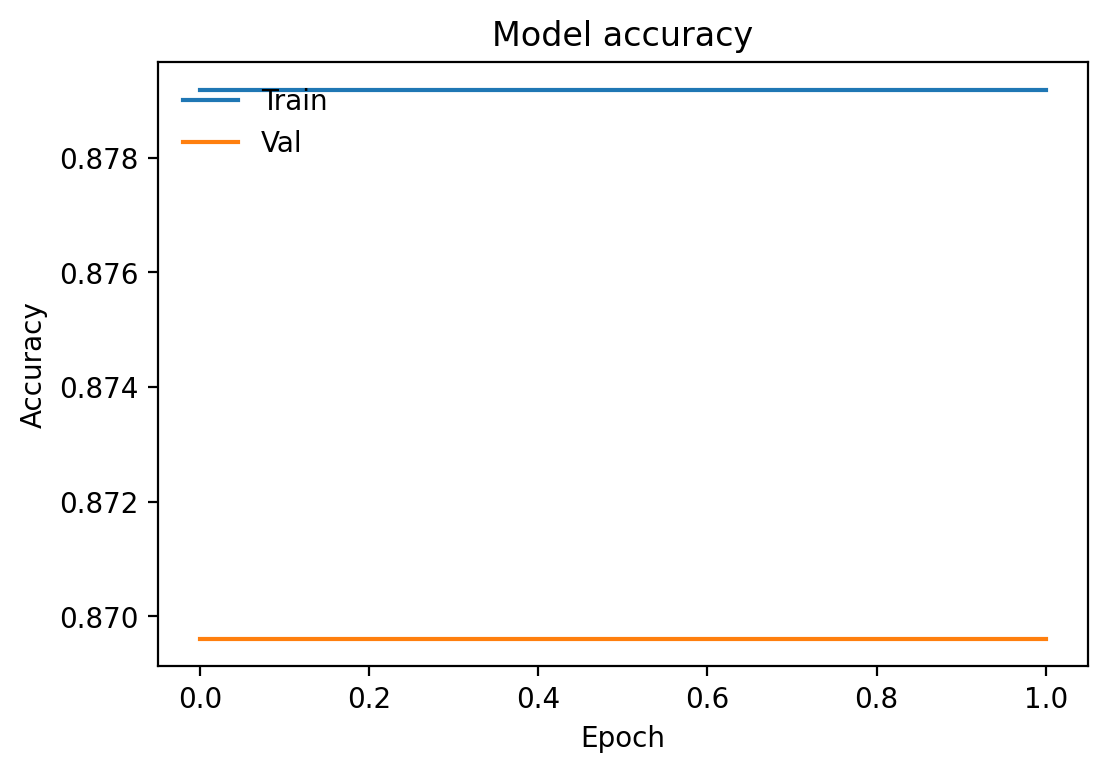

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc="upper left")
plt.show()

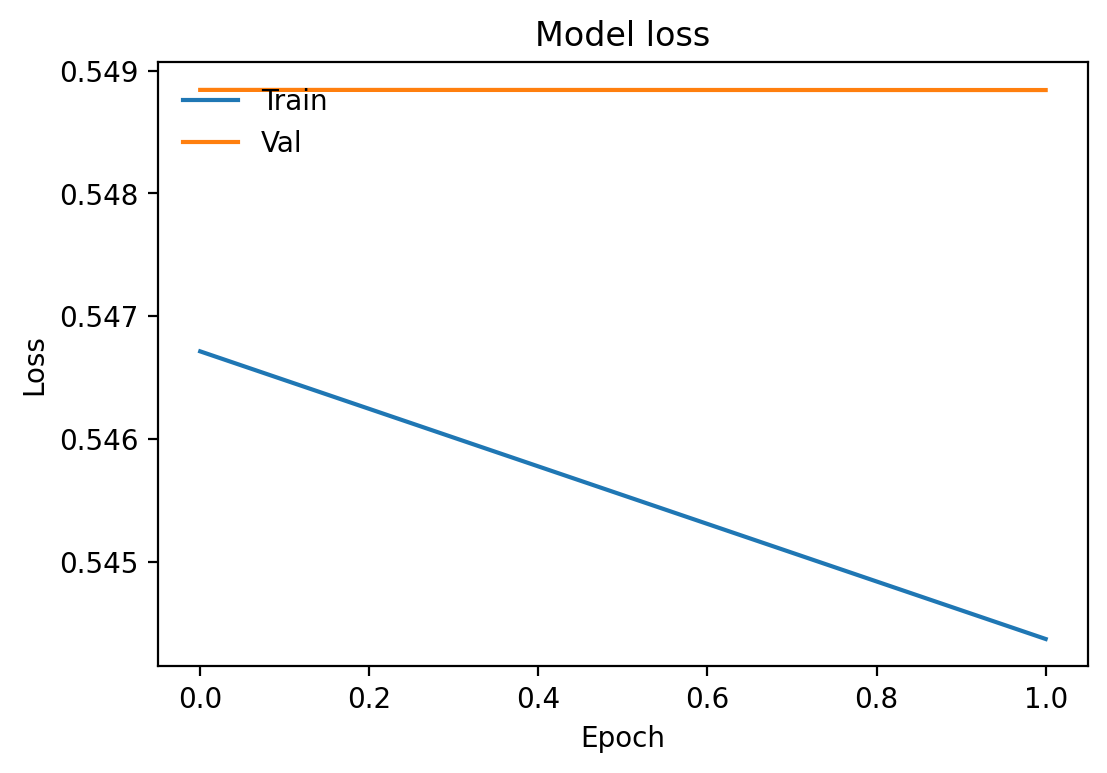

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc="upper left")
plt.show()

### Confusion matrix

In [ ]:
# To get a confusion matrix a prediction from the neural network is needed
y_pred= model_Psihas.predict([testing[0],testing[1]])

In [ ]:
mat = confusion_matrix(label_testing,y_pred_int)
# plot_confusion_matrix(conf_mat=mat, figsize=(10,10), class_names=class_names, show_normed=True)
print(mat)

[[   0  350]
 [   0 2710]]


The model had 190 475 parameters in total, 189 995 of which were trainable. The training was done on a batch of 25 during two epochs.

The loss was 0.3724. The accuracy was 0.8786.

The confusion matrix showed that 0 (0\%) pictures were correctly identified as NC events, and likewise, 2710 (88.6\%) were correctly identified as CC events. At the same time, 350 (11.4\%) events were classified as NC even though they were CC, and likewise, 0 (0\%) NC events were classified as CC.

The model clearly experienced over-training, as the accuracy on the validation set was lower than that on the training set.

See the report for the interpretation of the results.


# $\nu_{\mu}$-classifier (3.2-3.3)

## Developed neural network

### Neural network

As described in the report, this neural network is to be a replacement for the Psihas classifier which requires fewer trainable parameters to achieve the same accuracy. Some crucial architectural features remained, nonetheless -- most notably, the two-branch structure, as below.

In [ ]:
def branch(input_img):
    x_view_1=keras.layers.Conv2D(16, (4, 4), activation='relu', strides=2, input_shape=(100,80,1))(input_img)
    x_view_2=keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_1)
    x_view_3=BatchNormalization()(x_view_2)
    x_view_4=keras.layers.Conv2D(16, (4, 4), activation='relu', strides=2, input_shape=(100,80,1))(x_view_3)
    x_view_5=keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_4)
    x_view_6=BatchNormalization()(x_view_5)
    x_view_7=keras.layers.Dropout(0.2)(x_view_6)
    x_view_8=keras.layers.Flatten()(x_view_7)
    x_view_9=keras.layers.Dense(32, activation='relu')(x_view_8)
    return keras.layers.Dense(16, activation='relu')(x_view_9)

In [ ]:
#These need to be passed into the neural network for the compilation. Notice that the shapes matc those of the considered data.
input_img_1 = Input(shape=(100, 80, 1))
input_img_2 = Input(shape=(100, 80, 1))

Now, the two branches need to be joined.

In [ ]:
combined=concatenate([branch(input_img_1),branch(input_img_2)], axis=-1)
final=keras.layers.Dense(2, activation='sigmoid')(combined)
final_2=tf.keras.layers.Softmax(axis=-1)(final)

In [ ]:
classifier= Model(inputs=[input_img_1,input_img_2], outputs=[final_2])
classifier.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])

In [ ]:
classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 49, 39, 16)   272         ['input_1[0][0]']                
                                                                                              

The model has 16 354 parameters in total, 16 226 of which are trainable. This is a reduction of the order of magnitude as compared to the Psihas model.

### Training

Training is one of the finest and hardest to master of the competencies in the machine learning craft. To get it right, three different approaches were contrasted:
1. Imbalanced data, big batch, few epochs
2. Imbalanced data, small-batch, more epochs than in 1.
3. Balanced data, small-batch, more epochs than in 1.
The comparison of 1 and 2, and 2 and 3 will render precedence for the later work in this notebook.

In [ ]:
history_classifier=classifier.fit([training[0],training[1]], label_training, batch_size=100, epochs=2, validation_data=([validation[0],validation[1]], label_validation))

Epoch 1/2
223/223 [==============================] - 37s 160ms/step - loss: 0.6937 - accuracy: 0.4966 - val_loss: 0.6931 - val_accuracy: 0.8431
Epoch 2/2
223/223 [==============================] - 33s 147ms/step - loss: 0.6932 - accuracy: 0.4510 - val_loss: 0.6931 - val_accuracy: 0.6665


In [ ]:
history_classifier_smaller_batch=classifier.fit([training[0],training[1]], label_training, batch_size=25, epochs=8, validation_data=([validation[0],validation[1]], label_validation))

Epoch 1/8
891/891 [==============================] - 41s 45ms/step - loss: 0.6934 - accuracy: 0.4104 - val_loss: 0.6932 - val_accuracy: 0.3610
Epoch 2/8
891/891 [==============================] - 39s 44ms/step - loss: 0.6932 - accuracy: 0.4028 - val_loss: 0.6931 - val_accuracy: 0.3722
Epoch 3/8
891/891 [==============================] - 40s 44ms/step - loss: 0.6932 - accuracy: 0.4151 - val_loss: 0.6931 - val_accuracy: 0.3998
Epoch 4/8
891/891 [==============================] - 40s 44ms/step - loss: 0.6932 - accuracy: 0.4041 - val_loss: 0.6931 - val_accuracy: 0.3662
Epoch 5/8
891/891 [==============================] - 40s 45ms/step - loss: 0.6932 - accuracy: 0.3804 - val_loss: 0.6931 - val_accuracy: 0.3898
Epoch 6/8
891/891 [==============================] - 40s 45ms/step - loss: 0.6932 - accuracy: 0.4154 - val_loss: 0.6931 - val_accuracy: 0.3466
Epoch 7/8
891/891 [==============================] - 40s 45ms/step - loss: 0.6932 - accuracy: 0.4033 - val_loss: 0.6931 - val_accuracy: 0.3874

In [ ]:
history_classifier_smaller_batch_bal=classifier.fit([training[0],training[1]], label_training, batch_size=25, epochs=8, validation_data=([validation[0],validation[1]], label_validation))

Epoch 1/8
309/309 [==============================] - 14s 41ms/step - loss: 0.6938 - accuracy: 0.4926 - val_loss: 0.6932 - val_accuracy: 0.5006
Epoch 2/8
309/309 [==============================] - 12s 40ms/step - loss: 0.6932 - accuracy: 0.5038 - val_loss: 0.6932 - val_accuracy: 0.5178
Epoch 3/8
309/309 [==============================] - 12s 40ms/step - loss: 0.6931 - accuracy: 0.5056 - val_loss: 0.6931 - val_accuracy: 0.5224
Epoch 4/8
309/309 [==============================] - 13s 41ms/step - loss: 0.6931 - accuracy: 0.5045 - val_loss: 0.6931 - val_accuracy: 0.5155
Epoch 5/8
309/309 [==============================] - 12s 40ms/step - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6931 - val_accuracy: 0.5098
Epoch 6/8
309/309 [==============================] - 13s 41ms/step - loss: 0.6931 - accuracy: 0.5085 - val_loss: 0.6931 - val_accuracy: 0.5109
Epoch 7/8
309/309 [==============================] - 13s 41ms/step - loss: 0.6931 - accuracy: 0.5006 - val_loss: 0.6931 - val_accuracy: 0.5190

### Results

#### Imbalanced data, big batch, few epochs

In [ ]:
test_loss_classifier, test_acc_classifier = classifier.evaluate([testing[0],testing[1]], label_testing, verbose=2)

96/96 - 2s - loss: 0.6931 - accuracy: 0.6739 - 2s/epoch - 17ms/step


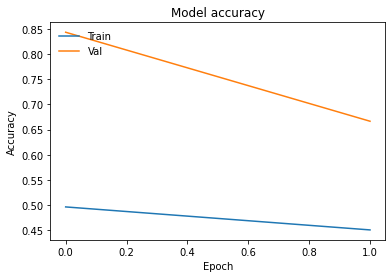

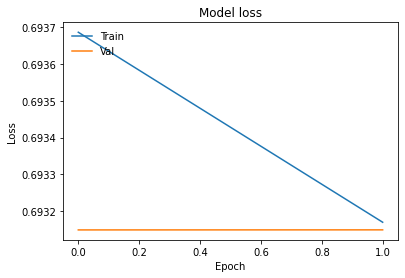

In [ ]:
plt.plot(history_classifier.history['accuracy'])
plt.plot(history_classifier.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc="upper left")
plt.show()

plt.plot(history_classifier.history['loss'])
plt.plot(history_classifier.history['val_loss'])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc="upper left")
plt.show()

In [ ]:
# To get a confusion matrix a prediction from the neural network is needed
y_pred_classifier= classifier.predict([testing[0],testing[1]])
print(y_pred_classifier.shape)

(3060, 2)


In [ ]:
print(y_pred_classifier)

[[0.5018882  0.49811178]
 [0.5013526  0.49864733]
 [0.4986118  0.50138813]
 ...
 [0.49875328 0.50124675]
 [0.49988514 0.50011486]
 [0.49994725 0.5000528 ]]


In [ ]:
y_pred_classifier_int=np.zeros(3060)
for i in range(3060):
    if y_pred_classifier[i][0]>y_pred_classifier[i][1]:
        y_pred_classifier_int[i]=0
    else:
        y_pred_classifier_int[i]=1


mat_classifier = confusion_matrix(label_testing,y_pred_classifier_int)
# plot_confusion_matrix(conf_mat=mat, figsize=(10,10), class_names=class_names, show_normed=True)
print(mat_classifier)

[[ 110  266]
 [ 732 1952]]


#### Imbalanced data, small-batch, more epochs than in 1.

In [ ]:
# Smaller batch size, more epochs
test_loss_classifier, test_acc_classifier = classifier.evaluate([testing[0],testing[1]], label_testing, verbose=2)

96/96 - 2s - loss: 0.6931 - accuracy: 0.3925 - 2s/epoch - 18ms/step


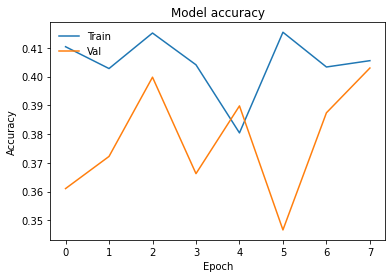

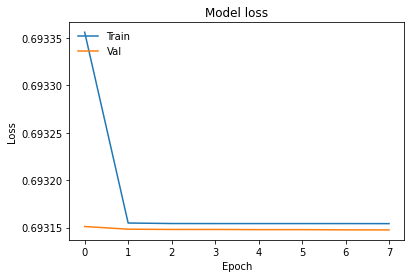

In [ ]:
#Smaller batch, more epochs
plt.plot(history_classifier_smaller_batch.history['accuracy'])
plt.plot(history_classifier_smaller_batch.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc="upper left")
plt.show()

plt.plot(history_classifier_smaller_batch.history['loss'])
plt.plot(history_classifier_smaller_batch.history['val_loss'])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc="upper left")
plt.show()

In [ ]:
# Smaller batch, more epochs
# To get a confusion matrix a prediction from the neural network is needed
y_pred_classifier= classifier.predict([testing[0],testing[1]])
print(y_pred_classifier.shape)

(3060, 2)


In [ ]:
# Smaller batch, more epochs
y_pred_classifier_int=np.zeros(3060)
for i in range(3060):
    if y_pred_classifier[i][0]>y_pred_classifier[i][1]:
        y_pred_classifier_int[i]=0
    else:
        y_pred_classifier_int[i]=1


mat_classifier = confusion_matrix(label_testing,y_pred_classifier_int)
# plot_confusion_matrix(conf_mat=mat, figsize=(10,10), class_names=class_names, show_normed=True)
print(mat_classifier)

[[ 210  132]
 [1627 1091]]


#### Balanced data, small-batch, more epochs than in 1.

In [ ]:
test_loss_classifier, test_acc_classifier = classifier.evaluate([testing[0],testing[1]], label_testing, verbose=2)

34/34 - 1s - loss: 0.6931 - accuracy: 0.4934 - 520ms/epoch - 15ms/step


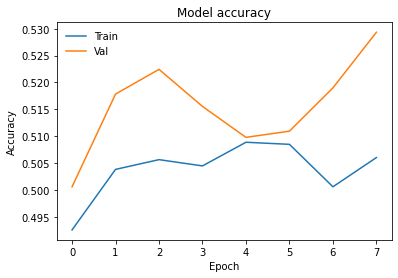

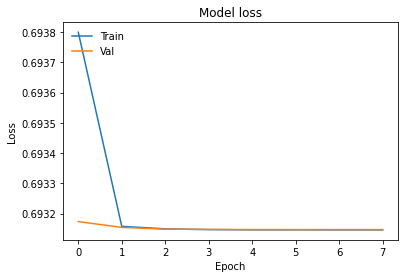

In [ ]:
#Smaller batch, more epochs, balanced data
plt.plot(history_classifier_smaller_batch_bal.history['accuracy'])
plt.plot(history_classifier_smaller_batch_bal.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc="upper left")
plt.show()

plt.plot(history_classifier_smaller_batch_bal.history['loss'])
plt.plot(history_classifier_smaller_batch_bal.history['val_loss'])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc="upper left")
plt.show()

In [ ]:
# Smaller batch, more epochs
# To get a confusion matrix a prediction from the neural network is needed
y_pred_classifier= classifier.predict([testing[0],testing[1]])
print(y_pred_classifier.shape)

(1062, 2)


In [ ]:
# Smaller batch, more epochs
y_pred_classifier_int=np.zeros(1062)
for i in range(1062):
    if y_pred_classifier[i][0]>y_pred_classifier[i][1]:
        y_pred_classifier_int[i]=0
    else:
        y_pred_classifier_int[i]=1


mat_classifier = confusion_matrix(label_testing,y_pred_classifier_int)
# plot_confusion_matrix(conf_mat=mat, figsize=(10,10), class_names=class_names, show_normed=True)
print(mat_classifier)

[[160 401]
 [136 365]]


**Imbalanced data**
The model had 16 354 parameters in total, 16 226 of which were trainable. This is a reduction of the order of magnitude as compared to the Psihas model.

Two approaches to training were adopted. In the first case, the batch size was 100 and the training lasted for two epochs. In the second case, the batch size was 25 and the training lasted for eight epochs.

While the losses were the same for both and equalled 0.6931, the first model performed significantly better than the one with a smaller batch size in terms of accuracy: 0.6739 v. 0.3925.

Greater insight can be gained by analysing the confusion matrices.
> For the model trained on the bigger batch, 110 pictures were correctly identified as NC events, and likewise, 1952 were correctly identified as CC events. At the same time, 266 events were classified as NC even though they were CC, and likewise, 732 NC events were classified as CC.

> For the model trained on the smaller batch, 210 pictures were correctly identified as NC events, and likewise, 1051 were correctly identified as CC events. At the same time, 132 events were classified as NC even though they were CC, and likewise, 1627 NC events were classified as CC.

Another difference between the two approaches was the over-fitting: the performance of the model trained on a bigger batch was better and did not show the over-fitting whilst the model trained on a smaller batch over-fitted. This is the case as the accuracy on the training set was lower than that on the validation set for the first model. Despite fluctuations, the opposite was generally true for the model trained on the smaller batch.

**Balanced data**

The claim that the CC/NC-unevenness of the data influenced the training and testing performance was looked into. The data was down-sampled probabilistically so that the number of CC and NC events supplied for training were equal. In detail, the events corresponding to "one"s were removed from the data put into the $\mathrm{training\_test\_split()}$ in the quantity stemming from the number of "zero"s.

The model had  16 354 parameters in total, 16 226 of which were trainable.

The loss was invariantly 0.6931. As compared to the approach from 4.2.1, the accuracy was improved -- it reached 0.4934.

The confusion matrix reflects these changes. Now, 160 (15.1\%) pictures were correctly identified as NC events, and likewise, 365 (34.4\%) were correctly identified as CC events. At the same time, 401 (37.8\%) events were classified as NC even though they were CC, and likewise, 136 (12.8\%) NC events were classified as CC.

Over-fitting was not the case.

## More convolution layers (3.3.1)

### Neural network

The rationale behind adding more convolution layers is that the netowrk might not have identified the principal themes of the signal enough. Therefore, a bottlenecking technique is applied. The branches are added to with a few more convolution layers followed by the up-sampling layers. 

In [ ]:
def branch_bottlenecking(input_img):
    # detection of the underlying patterns through convolution layers
    x_view_1=keras.layers.Conv2D(16, (4, 4), activation='relu', strides=2, input_shape=(100,80,1))(input_img)
    x_view_2=keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_1)
    x_view_3=BatchNormalization()(x_view_2)
    x_view_4=keras.layers.Conv2D(16, (4, 4), activation='relu', strides=2, input_shape=(100,80,1))(x_view_3)
    x_view_5=keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_4)
    x_view_6=BatchNormalization()(x_view_5)

    #bottlenecking
    x_view_7=keras.layers.Conv2D(3,3,activation="relu",padding='same')(x_view_6)   # down
    x_view_8=keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_6)
    x_view_9=keras.layers.Dropout(0.2)(x_view_8)                                    # a dropout layer to eliminate overfocusing on some features of the training dataset
    x_view_10=keras.layers.Conv2D(3,3,activation="relu",padding='same')(x_view_9)  # down
    x_view_11=keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_10)
    x_view_12=keras.layers.UpSampling2D(size=(1,1))(x_view_11)                      # up
    x_view_13=keras.layers.Conv2D(3,3,activation="relu",padding='same')(x_view_12)
    x_view_14=keras.layers.UpSampling2D(size=(9,9))(x_view_13)                      # up
    x_view_15=keras.layers.Conv2D(3,3,activation="relu",padding='same')(x_view_14)
    
    # dense layers
    x_view_16=keras.layers.Dropout(0.2)(x_view_15)
    x_view_17=keras.layers.Flatten()(x_view_16)
    x_view_18=keras.layers.Dense(32, activation='relu')(x_view_17)
    return keras.layers.Dense(16, activation='relu')(x_view_18)

In [ ]:
#These need to be passed into the neural network for the compilation. Notice that the shapes matc those of the considered data.
input_img_1 = Input(shape=(100, 80, 1))
input_img_2 = Input(shape=(100, 80, 1))

In [ ]:
combined=concatenate([branch_bottlenecking(input_img_1),branch_bottlenecking(input_img_2)], axis=-1)    # change appropriately, i.e., the branch() to branch_conv()
final=keras.layers.Dense(2, activation='sigmoid')(combined)
final_2=tf.keras.layers.Softmax(axis=-1)(final)

In [ ]:
classifier_bottlenecking= Model(inputs=[input_img_1,input_img_2], outputs=[final_2])
classifier_bottlenecking.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])

In [ ]:
classifier_bottlenecking.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 49, 39, 16)   272         ['input_1[0][0]']                
                                                                                              

### Training

In [ ]:
history_classifier_bottlenecking=classifier_bottlenecking.fit([training[0],training[1]], label_training, batch_size=100, epochs=4, validation_data=([validation[0],validation[1]], label_validation))

Epoch 1/4
223/223 [==============================] - 38s 165ms/step - loss: 0.6931 - accuracy: 0.5080 - val_loss: 0.6931 - val_accuracy: 0.8367
Epoch 2/4
223/223 [==============================] - 38s 169ms/step - loss: 0.6931 - accuracy: 0.4934 - val_loss: 0.6931 - val_accuracy: 0.8802
Epoch 3/4
223/223 [==============================] - 38s 170ms/step - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6931 - val_accuracy: 0.1238
Epoch 4/4
223/223 [==============================] - 38s 170ms/step - loss: 0.6931 - accuracy: 0.4874 - val_loss: 0.6931 - val_accuracy: 0.8383


### Results

In [ ]:
test_loss_classifier_bottlenecking, test_acc_classifier_bottlenecking = classifier_bottlenecking.evaluate([testing[0],testing[1]], label_testing, verbose=2)

96/96 - 2s - loss: 0.6931 - accuracy: 0.8422 - 2s/epoch - 20ms/step


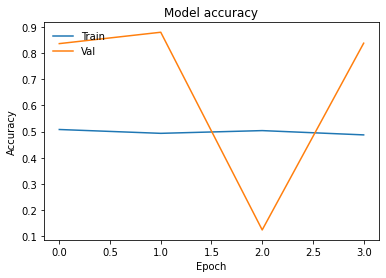

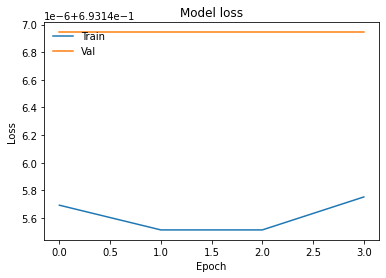

In [ ]:
plt.plot(history_classifier_bottlenecking.history['accuracy'])
plt.plot(history_classifier_bottlenecking.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc="upper left")
plt.show()

plt.plot(history_classifier_bottlenecking.history['loss'])
plt.plot(history_classifier_bottlenecking.history['val_loss'])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc="upper left")
plt.show()

In [ ]:
# To get a confusion matrix a prediction from the neural network is needed
y_pred_classifier_bottlenecking= classifier_bottlenecking.predict([testing[0],testing[1]])
print(y_pred_classifier_bottlenecking.shape)

(3060, 2)


In [ ]:
y_pred_classifier_bottlenecking_int=np.zeros(3060)
for i in range(3060):
    if y_pred_classifier_bottlenecking[i][0]>y_pred_classifier_bottlenecking[i][1]:
        y_pred_classifier_bottlenecking_int[i]=0
    else:
        y_pred_classifier_bottlenecking_int[i]=1

mat_classifier_bottlenecking = confusion_matrix(label_testing,y_pred_classifier_bottlenecking_int)
print(mat_classifier_bottlenecking)

[[  20  322]
 [ 159 2559]]


The model had 26 968  parameters in total, 26 840 of which were trainable.
The training was done on a batch of 100 during four epochs -- see Discussion for more information.

The loss was invariantly 0.6931. As compared to both approaches from 4.2, the accuracy was improved -- it reached 0.8422.

The confusion matrix reflects these changes. Now, 20 (0.7\%) pictures were correctly identified as NC events, and likewise, 2559 (83.6\%) were correctly identified as CC events. At the same time, 322 (10.5\%) events were classified as NC even though they were CC, and likewise, 159 (5.2\%) NC events were classified as CC.

Again, over-fitting was not the case, as the accuracy on the validation set usually remained higher than that on the training set.

## More dense layers (3.3.2)

### Neural network

As explained in the report, it is possible that the convolution layers have correctly identified the general themes of data, but it has not been processed by the network enough. Hence, a few more dense layers are added in each branch of the network. It is worth noting that the activation function throughout the model stays relu, as the data is mostly pixelish and does not require much softening.

In [ ]:
def branch_dense(input_img):
    x_view_1=keras.layers.Conv2D(16, (4, 4), activation='relu', strides=2, input_shape=(100,80,1))(input_img)
    x_view_2=keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_1)
    x_view_3=BatchNormalization()(x_view_2)
    x_view_4=keras.layers.Dense(32, activation='relu')(x_view_3)                                                # this is different
    x_view_5=keras.layers.Conv2D(16, (4, 4), activation='relu', strides=2, input_shape=(100,80,1))(x_view_4)
    x_view_6=keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_5)
    x_view_7=BatchNormalization()(x_view_6)
    x_view_8=keras.layers.Dense(32, activation='relu')(x_view_7)                                                # this is different
    x_view_9=keras.layers.Dropout(0.2)(x_view_8)
    x_view_10=keras.layers.Flatten()(x_view_9)
    x_view_11=keras.layers.Dense(32, activation='relu')(x_view_10)
    x_view_12=keras.layers.Dense(32, activation='relu')(x_view_11)                                              # this is different            
    x_view_13=keras.layers.Dense(32, activation='relu')(x_view_12)                                              # this is different    
    return keras.layers.Dense(16, activation='relu')(x_view_13)

In [ ]:
#These need to be passed into the neural network for the compilation. Notice that the shapes matc those of the considered data.
input_img_1 = Input(shape=(100, 80, 1))
input_img_2 = Input(shape=(100, 80, 1))

In [ ]:
combined=concatenate([branch_dense(input_img_1),branch_dense(input_img_2)], axis=-1)
final_1=keras.layers.Dense(10, activation='relu')(combined)
final_2=keras.layers.Dense(2, activation='sigmoid')(final_1)
final_3=tf.keras.layers.Softmax(axis=-1)(final_2)

In [ ]:
classifier_dense= Model(inputs=[input_img_1,input_img_2], outputs=[final_3])
classifier_dense.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])

In [ ]:
classifier_dense.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 49, 39, 16)   272         ['input_1[0][0]']                
                                                                                            

The model has 37 376 parameters in total, 37 248 of which are trainable. This is a reduction of the order of magnitude as compared to the Psihas model.

### Training

In [ ]:
history_classifier_dense=classifier_dense.fit([training[0],training[1]], label_training, batch_size=100, epochs=4, validation_data=([validation[0],validation[1]], label_validation))

Epoch 1/4
223/223 [==============================] - 48s 208ms/step - loss: 0.6932 - accuracy: 0.5238 - val_loss: 0.6931 - val_accuracy: 0.8794
Epoch 2/4
223/223 [==============================] - 45s 201ms/step - loss: 0.6931 - accuracy: 0.5063 - val_loss: 0.6931 - val_accuracy: 0.7113
Epoch 3/4
223/223 [==============================] - 45s 202ms/step - loss: 0.6931 - accuracy: 0.5098 - val_loss: 0.6931 - val_accuracy: 0.6218
Epoch 4/4
223/223 [==============================] - 46s 208ms/step - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6931 - val_accuracy: 0.6577


### Results

In [ ]:
test_loss_classifier_dense, test_acc_classifier_dense = classifier_dense.evaluate([testing[0],testing[1]], label_testing, verbose=2)

96/96 - 2s - loss: 0.6931 - accuracy: 0.6235 - 2s/epoch - 20ms/step


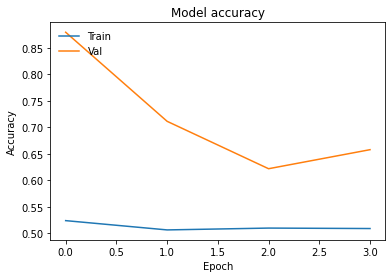

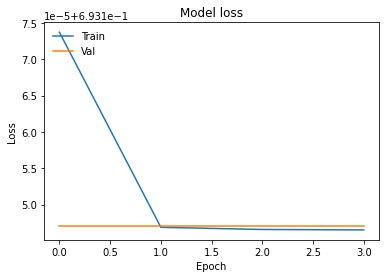

In [ ]:
plt.plot(history_classifier_dense.history['accuracy'])
plt.plot(history_classifier_dense.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc="upper left")
plt.show()

plt.plot(history_classifier_dense.history['loss'])
plt.plot(history_classifier_dense.history['val_loss'])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc="upper left")
plt.show()

In [ ]:
# To get a confusion matrix a prediction from the neural network is needed
y_pred_classifier_dense= classifier_dense.predict([testing[0],testing[1]])
print(y_pred_classifier_dense.shape)

(3060, 2)


In [ ]:
y_pred_classifier_dense_int=np.zeros(3060)
for i in range(3060):
    if y_pred_classifier_dense[i][0]>y_pred_classifier_dense[i][1]:
        y_pred_classifier_dense_int[i]=0
    else:
        y_pred_classifier_dense_int[i]=1

mat_classifier_dense = confusion_matrix(label_testing,y_pred_classifier_dense_int)
print(mat_classifier_dense)

[[ 100  257]
 [ 895 1808]]


The model had 37 376 parameters in total, 37 248 of which were trainable.

Given the results from section 4.2, the training was done on a batch of 100 during four epochs -- see Discussion for more information.

The loss was invariantly 0.6931. The accuracy was improved only as compared to the $\nu_{\mu}$-classifier trained on the smaller batch. It reached 0.6235.

The confusion matrix indicated that this time 100 (3.3\%) pictures were correctly identified as NC events, and likewise, 1808 (59.1\%) were correctly identified as CC events. At the same time, 257 (8.4\%) events were classified as NC even though they were CC, and likewise, 895 (29.2\%) NC events were classified as CC.

Again, over-fitting was not the case, as the accuracy on the validation set usually remained higher than that on the training set.

## Noise (3.3.3)

### Neural network (noise added to pictures)

The network stays the same as in the original construction.

Let the noise be added to the pictures themselves, though. By seeing what effect it has on efficiency, conclusions can be made. For the discussion about the size of the noise, see the report.

### Training

In [ ]:
history_classifier_noise=classifier.fit([training[0],training[1]], label_training, batch_size=100, epochs=2, validation_data=([validation[0],validation[1]], label_validation))

Epoch 1/2
223/223 [==============================] - 38s 166ms/step - loss: 0.6931 - accuracy: 0.4624 - val_loss: 0.6931 - val_accuracy: 0.4161
Epoch 2/2
223/223 [==============================] - 37s 167ms/step - loss: 0.6931 - accuracy: 0.4724 - val_loss: 0.6931 - val_accuracy: 0.4844


### Results

In [ ]:
test_loss_classifier_noise, test_acc_classifier_noise = classifier.evaluate([testing[0],testing[1]], label_testing, verbose=2)

96/96 - 2s - loss: 0.6931 - accuracy: 0.4895 - 2s/epoch - 17ms/step


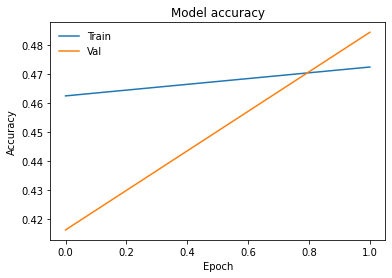

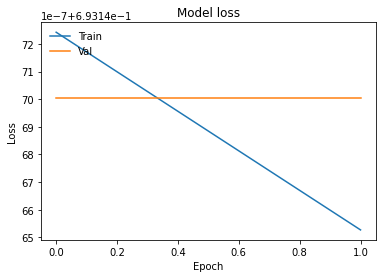

In [ ]:
plt.plot(history_classifier_noise.history['accuracy'])
plt.plot(history_classifier_noise.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc="upper left")
plt.show()

plt.plot(history_classifier_noise.history['loss'])
plt.plot(history_classifier_noise.history['val_loss'])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc="upper left")
plt.show()

In [ ]:
# To get a confusion matrix a prediction from the neural network is needed
y_pred_classifier_noise= classifier.predict([testing[0],testing[1]])
print(y_pred_classifier_noise.shape)

(3060, 2)


In [ ]:
# Smaller batch, more epochs
y_pred_classifier_noise_int=np.zeros(3060)
for i in range(3060):
    if y_pred_classifier_noise[i][0]>y_pred_classifier_noise[i][1]:
        y_pred_classifier_noise_int[i]=0
    else:
        y_pred_classifier_noise_int[i]=1


mat_classifier_noise = confusion_matrix(label_testing,y_pred_classifier_noise_int)
# plot_confusion_matrix(conf_mat=mat, figsize=(10,10), class_names=class_names, show_normed=True)
print(mat_classifier_noise)

[[ 168  192]
 [1336 1364]]


### Neural network (GaussianNoise)

In the previous approach, the network could learn the pre-added noise, which in a way made its choice arbitrary. Now, the addition of the NoisyDense layer will generate different noise every time an image is passed through the network. This prevents the model from learning the noise, which regularises the model.

In [ ]:
def branch_noise(input_img):
    x_view_1=keras.layers.Conv2D(16, (4, 4), activation='relu', strides=2, input_shape=(100,80,1))(input_img)
    x_view_2=keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_1)
    x_view_3=tf.keras.layers.GaussianNoise(0.005)(x_view_2)                                       # this is different
    x_view_4=BatchNormalization()(x_view_3)
    x_view_5=keras.layers.Dropout(0.2)(x_view_4)
    x_view_6=keras.layers.Conv2D(16, (4, 4), activation='relu', strides=2, input_shape=(100,80,1))(x_view_5)
    x_view_7=keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_6)
    x_view_8=BatchNormalization()(x_view_7)
    x_view_9=keras.layers.Flatten()(x_view_8)
    x_view_10=keras.layers.Dense(32, activation='relu')(x_view_9)
    x_view_11=tf.keras.layers.GaussianNoise(0.005)(x_view_10)                                        # this is different
    return keras.layers.Dense(16, activation='relu')(x_view_11)

In [ ]:
#These need to be passed into the neural network for the compilation. Notice that the shapes matc those of the considered data.
input_img_1 = Input(shape=(100, 80, 1))
input_img_2 = Input(shape=(100, 80, 1))

In [ ]:
combined=concatenate([branch_noise(input_img_1),branch_noise(input_img_2)], axis=-1) # join two new branches
final=keras.layers.Dense(2, activation='sigmoid')(combined)
final_2=tf.keras.layers.Softmax(axis=-1)(final)

In [ ]:
classifier_noise_GaussianNoise= Model(inputs=[input_img_1,input_img_2], outputs=[final_2])
classifier_noise_GaussianNoise.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])

In [ ]:
classifier_noise_GaussianNoise.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_4 (Conv2D)              (None, 49, 39, 16)   272         ['input_1[0][0]']                
                                                                                            

### Training

In [ ]:
history_classifier_Gaussian=classifier_noise_GaussianNoise.fit([training[0],training[1]], label_training, batch_size=100, epochs=2, validation_data=([validation[0],validation[1]], label_validation))

Epoch 1/2
223/223 [==============================] - 40s 177ms/step - loss: 0.6952 - accuracy: 0.1656 - val_loss: 0.6931 - val_accuracy: 0.1158
Epoch 2/2
223/223 [==============================] - 38s 172ms/step - loss: 0.6939 - accuracy: 0.1365 - val_loss: 0.6931 - val_accuracy: 0.1158


### Results

In [ ]:
test_loss_classifierclassifier_noise_GaussianNoise, test_acc_classifierclassifier_noise_GaussianNoise = classifier_noise.evaluate([testing[0],testing[1]], label_testing, verbose=2)

96/96 - 2s - loss: 0.6931 - accuracy: 0.1144 - 2s/epoch - 17ms/step


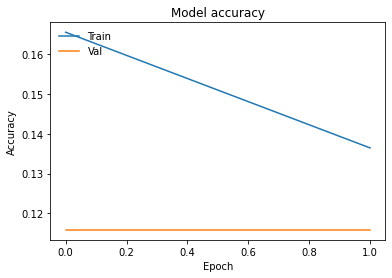

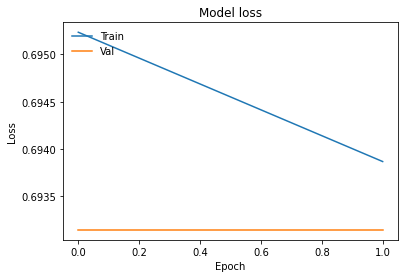

In [ ]:
plt.plot(history_classifier_Gaussian.history['accuracy'])
plt.plot(history_classifier_Gaussian.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc="upper left")
plt.show()

plt.plot(history_classifier_Gaussian.history['loss'])
plt.plot(history_classifier_Gaussian.history['val_loss'])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc="upper left")
plt.show()

In [ ]:
# To get a confusion matrix a prediction from the neural network is needed
y_pred_classifier_noise_Gaussian= classifier_noise_GaussianNoise.predict([testing[0],testing[1]])
print(y_pred_classifier_noise_Gaussian.shape)

(3060, 2)


In [ ]:
# Smaller batch, more epochs
y_pred_classifier_noise_Gaussian_int=np.zeros(3060)
for i in range(3060):
    if y_pred_classifier_noise_Gaussian[i][0]>y_pred_classifier_noise_Gaussian[i][1]:
        y_pred_classifier_noise_Gaussian_int[i]=0
    else:
        y_pred_classifier_noise_Gaussian_int[i]=1


mat_classifier_noise_Gaussian = confusion_matrix(label_testing,y_pred_classifier_noise_Gaussian_int)
# plot_confusion_matrix(conf_mat=mat, figsize=(10,10), class_names=class_names, show_normed=True)
print(mat_classifier_noise_Gaussian)

[[   0  350]
 [   0 2710]]


The two approaches to adding noise gave differing results. To understand them, let the models be presented. The processing of pictures with pre-added noise was done with the initial $\nu_{\mu}$-classifier for the imbalanced data. The model with noise layers had 16 354 parameters in total, 16 226 of which were trainable.

As the complexity of the models did not increase as compared to the model trained on the greater batch, the training in both cases was done on the batch of 100 for two epochs.

The loss was invariantly 0.6931. The accuracy dropped in both cases as compared to the $\nu_{\mu}$-classifier trained on the greater batch. For the case of pre-noised pictures, it reached 0.4895, while for the model with the noise layers, it reached 0.1144.

The confusion matrix for the former model indicated that this time, 168 (5.5\%) pictures were correctly identified as NC events, and likewise, 1364 (44.6\%) were correctly identified as CC events. At the same time, 192 (6.3\%) events were classified as NC even though they were CC, and likewise, 1336 (43.7\%) NC events were classified as CC.

The confusion matrix for the latter model indicated that 0 (0\%) pictures were correctly identified as NC events, and likewise, 2710 (88.6\%) were correctly identified as CC events. At the same time, 350 (11.4\%) events were classified as NC even though they were CC, and likewise, 0 (0\%) NC events were classified as CC.

Over-fitting was not the case for the model with pre-noised pictures by contrast to the other model.

## More dropouts (3.3.4)

### Neural network

Each branch makes the dropping out more repetitive: instead of a single dropout layer with 20% of weights set to zero, now, three layers with 30% dropout were added.

In [ ]:
def branch_dropout(input_img):
    x_view_1=keras.layers.Conv2D(16, (4, 4), activation='relu', strides=2, input_shape=(100,80,1))(input_img)
    x_view_2=keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_1)
    x_view_3=BatchNormalization()(x_view_2)
    x_view_4=keras.layers.Dropout(0.3)(x_view_3)                                                                # this is different
    x_view_5=keras.layers.Conv2D(16, (4, 4), activation='relu', strides=2, input_shape=(100,80,1))(x_view_4)
    x_view_6=keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_5)
    x_view_7=BatchNormalization()(x_view_6)
    x_view_8=keras.layers.Dropout(0.3)(x_view_7)                                                                # this is different
    x_view_9=keras.layers.Flatten()(x_view_8)
    x_view_10=keras.layers.Dense(32, activation='relu')(x_view_9)
    x_view_11=keras.layers.Dropout(0.3)(x_view_10)                                                              # this is different
    return keras.layers.Dense(16, activation='relu')(x_view_11)

In [ ]:
#These need to be passed into the neural network for the compilation. Notice that the shapes matc those of the considered data.
input_img_1 = Input(shape=(100, 80, 1))
input_img_2 = Input(shape=(100, 80, 1))

In [ ]:
combined=concatenate([branch_dropout(input_img_1),branch_dropout(input_img_2)], axis=-1) # join two new branches
final=keras.layers.Dense(2, activation='sigmoid')(combined)
final_2=tf.keras.layers.Softmax(axis=-1)(final)

In [ ]:
classifier_dropouts= Model(inputs=[input_img_1,input_img_2], outputs=[final_2])
classifier_dropouts.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])

In [ ]:
classifier_dropouts.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_6 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_14 (Conv2D)             (None, 49, 39, 16)   272         ['input_5[0][0]']                
                                                                                            

### Training

In [ ]:
history_classifier_dropouts=classifier_dropouts.fit([training[0],training[1]], label_training, batch_size=100, epochs=4, validation_data=([validation[0],validation[1]], label_validation))

Epoch 1/4
223/223 [==============================] - 40s 174ms/step - loss: 0.7153 - accuracy: 0.5405 - val_loss: 0.6932 - val_accuracy: 0.4972
Epoch 2/4
223/223 [==============================] - 38s 173ms/step - loss: 0.6932 - accuracy: 0.4705 - val_loss: 0.6932 - val_accuracy: 0.7141
Epoch 3/4
223/223 [==============================] - 39s 174ms/step - loss: 0.6932 - accuracy: 0.4630 - val_loss: 0.6931 - val_accuracy: 0.6921
Epoch 4/4
223/223 [==============================] - 39s 174ms/step - loss: 0.6932 - accuracy: 0.4629 - val_loss: 0.6931 - val_accuracy: 0.6829


### Results

In [ ]:
test_loss_classifier_dropouts, test_acc_classifier_dropouts = classifier_dropouts.evaluate([testing[0],testing[1]], label_testing, verbose=2)

96/96 - 2s - loss: 0.6931 - accuracy: 0.6559 - 2s/epoch - 18ms/step


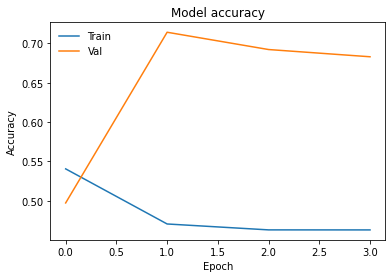

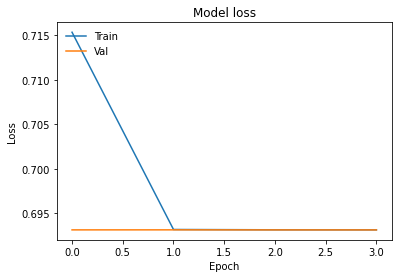

In [ ]:
plt.plot(history_classifier_dropouts.history['accuracy'])
plt.plot(history_classifier_dropouts.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc="upper left")
plt.show()

plt.plot(history_classifier_dropouts.history['loss'])
plt.plot(history_classifier_dropouts.history['val_loss'])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc="upper left")
plt.show()

In [ ]:
# To get a confusion matrix a prediction from the neural network is needed
y_pred_classifier_dropouts= classifier_dropouts.predict([testing[0],testing[1]])
print(y_pred_classifier_dropouts.shape)

(3060, 2)


In [ ]:
y_pred_classifier_dropouts_int=np.zeros(3060)
for i in range(3060):
    if y_pred_classifier_dropouts[i][0]>y_pred_classifier_dropouts[i][1]:
        y_pred_classifier_dropouts_int[i]=0
    else:
        y_pred_classifier_dropouts_int[i]=1

mat_classifier_dropouts = confusion_matrix(label_testing,y_pred_classifier_dropouts_int)
print(mat_classifier_dropouts)

[[  94  263]
 [ 763 1940]]


The model complexity did not chnage as compared to the initial $\nu_{\mu}$-clasifier in 4.2.

The training was done on a batch of 100 during four epochs -- see Discussion for more information.

The loss was invariantly 0.6931. The accuracy was 0.6559.

The confusion matrix indicated that this time 94 (3.1\%) pictures were correctly identified as NC events, and likewise, 1940 (63.4\%) were correctly identified as CC events. At the same time, 263 (8.6\%) events were classified as NC even though they were CC, and likewise, 763 (24.9\%) NC events were classified as CC.

Again, over-fitting was not the case.

#Extensions (3.4)

## Final state classifier (3.4.1)

### Data import

The task of identifying the final state is much more complex than the binary classifier because of the number of labels. Consequently, the number of neurons in the output layer changes. It is handy to adjust the size of the neural network by chacking how many final states there may be in the dataset. This is becuase the processing of some datasets may benefit from a less complicated network.

The processing of data changes marginally by swapping a[1] with a[0].

In [ ]:
training_finalstate, testing_finalstate, label_training_finalstate, label_testing_finalstate= train_test_split(big_df,a[0],test_size=0.2)
testing_finalstate, validation_finalstate, label_testing_finalstate, label_validation_finalstate = train_test_split(testing_finalstate, label_testing_finalstate,test_size=0.45)

This tells us how many labels are needed.

In [ ]:
number_of_labels=max(a[0])

Reshaping as before.

In [ ]:
training_finalstate=training_finalstate.reshape(2,-1,100,80)
testing_finalstate=testing_finalstate.reshape(2,-1,100,80)
validation_finalstate=validation_finalstate.reshape(2,-1,100,80)

### Neural network

Because of the increased complexity of the problem, the most suitable choice for this task would be the network that did best for the binary classifier, i.e., the one with more convolution layers. Some logical change will apply -- most notably the number of neurons in the output layer.

In [ ]:
def branch_bottlenecking(input_img):
    # detection of the underlying patterns through convolution layers
    x_view_1=keras.layers.Conv2D(16, (4, 4), activation='relu', strides=2, input_shape=(100,80,1))(input_img)
    x_view_2=keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_1)
    x_view_3=BatchNormalization()(x_view_2)
    x_view_4=keras.layers.Conv2D(16, (4, 4), activation='relu', strides=2, input_shape=(100,80,1))(x_view_3)
    x_view_5=keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_4)
    x_view_6=BatchNormalization()(x_view_5)

    #bottlenecking
    x_view_7=keras.layers.Conv2D(3,3,activation="relu",padding='same')(x_view_6)   # down
    x_view_8=keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_6)
    x_view_9=keras.layers.Dropout(0.2)(x_view_8)                                    # a dropout layer to eliminate overfocusing on some features of the training dataset
    x_view_10=keras.layers.Conv2D(3,3,activation="relu",padding='same')(x_view_9)  # down
    x_view_11=keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_10)
    x_view_12=keras.layers.UpSampling2D(size=(1,1))(x_view_11)                      # up
    x_view_13=keras.layers.Conv2D(3,3,activation="relu",padding='same')(x_view_12)
    x_view_14=keras.layers.UpSampling2D(size=(9,9))(x_view_13)                      # up
    x_view_15=keras.layers.Conv2D(3,3,activation="relu",padding='same')(x_view_14)
    
    # dense layers
    x_view_16=keras.layers.Dropout(0.2)(x_view_15)
    x_view_17=keras.layers.Flatten()(x_view_16)
    x_view_18=keras.layers.Dense(32, activation='relu')(x_view_17)
    return keras.layers.Dense(16, activation='relu')(x_view_18)

In [ ]:
#These need to be passed into the neural network for the compilation. Notice that the shapes matc those of the considered data.
input_img_1 = Input(shape=(100, 80, 1))
input_img_2 = Input(shape=(100, 80, 1))

In [ ]:
combined=concatenate([branch_bottlenecking(input_img_1),branch_bottlenecking(input_img_2)], axis=-1)
final=keras.layers.Dense(number_of_labels+1, activation='sigmoid')(combined)               # this changes depending on the dataset, and the edge-value needs to be included too
final_2=tf.keras.layers.Softmax(axis=-1)(final)

In [ ]:
classifier_finalstate= Model(inputs=[input_img_1,input_img_2], outputs=[final_2])
classifier_finalstate.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy']) # the BinaryCrossentropy() no longer can be used

In [ ]:
classifier_finalstate.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 49, 39, 16)   272         ['input_1[0][0]']                
                                                                                              

### Training

In [ ]:
history_classifier_finalstate=classifier_finalstate.fit([training_finalstate[0],training_finalstate[1]], label_training_finalstate, batch_size=25, epochs=4, validation_data=([validation_finalstate[0],validation_finalstate[1]], label_validation_finalstate))

Epoch 1/4
891/891 [==============================] - 45s 49ms/step - loss: 3.8947 - accuracy: 0.1488 - val_loss: 3.8946 - val_accuracy: 0.1518
Epoch 2/4
891/891 [==============================] - 42s 47ms/step - loss: 3.8947 - accuracy: 0.1489 - val_loss: 3.8946 - val_accuracy: 0.1550
Epoch 3/4
891/891 [==============================] - 43s 48ms/step - loss: 3.8947 - accuracy: 0.1488 - val_loss: 3.8946 - val_accuracy: 0.1530
Epoch 4/4
891/891 [==============================] - 43s 49ms/step - loss: 3.8947 - accuracy: 0.1483 - val_loss: 3.8946 - val_accuracy: 0.1526


### Results

In [ ]:
test_loss_classifier_finalstate, test_acc_classifier_finalstate = classifier_finalstate.evaluate([testing_finalstate[0],testing_finalstate[1]], label_testing_finalstate, verbose=2)

96/96 - 2s - loss: 3.8953 - accuracy: 0.1520 - 2s/epoch - 20ms/step


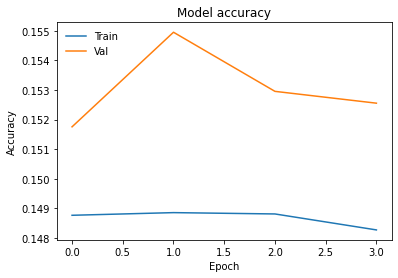

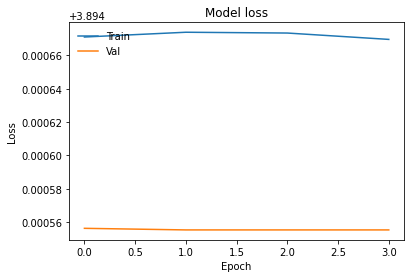

In [ ]:
plt.plot(history_classifier_finalstate.history['accuracy'])
plt.plot(history_classifier_finalstate.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc="upper left")
plt.show()

plt.plot(history_classifier_finalstate.history['loss'])
plt.plot(history_classifier_finalstate.history['val_loss'])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc="upper left")
plt.show()

In [ ]:
# To get a confusion matrix a prediction from the neural network is needed
y_pred_classifier_finalstate= classifier_finalstate.predict([testing_finalstate[0],testing_finalstate[1]])
print(y_pred_classifier_finalstate.shape)

(3060, 50)


In [ ]:
import random
y_pred_classifier_finalstate_int=np.zeros(3060)
for i in range(3060):
    l=y_pred_classifier_finalstate[i]
    max_value = max(l)
    result=np.where(l == max_value)
    y_pred_classifier_finalstate_int[i]=random.choice(result[0])

In [ ]:
print(y_pred_classifier_finalstate_int[])

12.0


In [ ]:
mat_classifier_finalstate = confusion_matrix(label_testing_finalstate,y_pred_classifier_finalstate_int)
print(mat_classifier_finalstate)

[[ 0  0  0 ...  0  0  3]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  3]
 [ 0  0  0 ...  0  0  2]
 [ 0  0  0 ...  0  0 14]]


In [ ]:
names={"Numu CC - no track no shower", "Numu CC - no track  1 shower",
    "Numu CC - no track  2 shower",
    "Numu CC - no track 3+ shower",
    "Numu CC -  1 track no shower",
    "Numu CC -  1 track  1 shower",
    "Numu CC -  1 track  2 shower",
    "Numu CC -  1 track 3+ shower",
    "Numu CC -  2 track no shower",
    "Numu CC -  2 track  1 shower",
    "Numu CC -  2 track  2 shower",
    "Numu CC -  2 track 3+ shower",
    "Numu CC - 3+ track no showe",
    "Numu CC - 3+ track  1 shower",
    "Numu CC - 3+ track  2 showe",
    "Numu CC - 3+ track 3+ shower",
    "Nue CC - no track no shower",
    "Nue CC - no track  1 shower",
    "Nue CC - no track  2 showe",
    "Nue CC - no track 3+ shower",
    "Nue CC -  1 track no shower",
    "Nue CC -  1 track  1 shower",
    "Nue CC -  1 track  2 shower",
    "Nue CC -  1 track 3+ shower",
    "Nue CC -  2 track no shower",
    "Nue CC -  2 track  1 shower",
    "Nue CC -  2 track  2 shower",
    "Nue CC -  2 track 3+ shower",
    "Nue CC - 3+ track no shower",
    "Nue CC - 3+ track  1 shower",
    "Nue CC - 3+ track  2 shower",
    "Nue CC - 3+ track 3+ shower",
    "NC CC - no track no shower",
    "NC CC - no track  1 shower",
    "NC CC - no track  2 shower",
    "NC CC - no track 3+ shower",
    "NC CC -  1 track no shower",
    "NC CC -  1 track  1 shower",
    "NC CC -  1 track  2 shower",
    "NC CC -  1 track 3+ shower",
    "NC CC -  2 track no shower",
    "NC CC -  2 track  1 shower",
    "NC CC -  2 track  2 shower",
    "NC CC -  2 track 3+ shower",
    "NC CC - 3+ track no shower",
    "NC CC - 3+ track  1 shower",
    "NC CC - 3+ track  2 shower",
    "NC CC - 3+ track 3+ shower",
    "Cosmic ray background",
    "Else",
    "Number of interaction types, used like a vector size"}

(<Figure size 2160x2160 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6a82b0e510>)

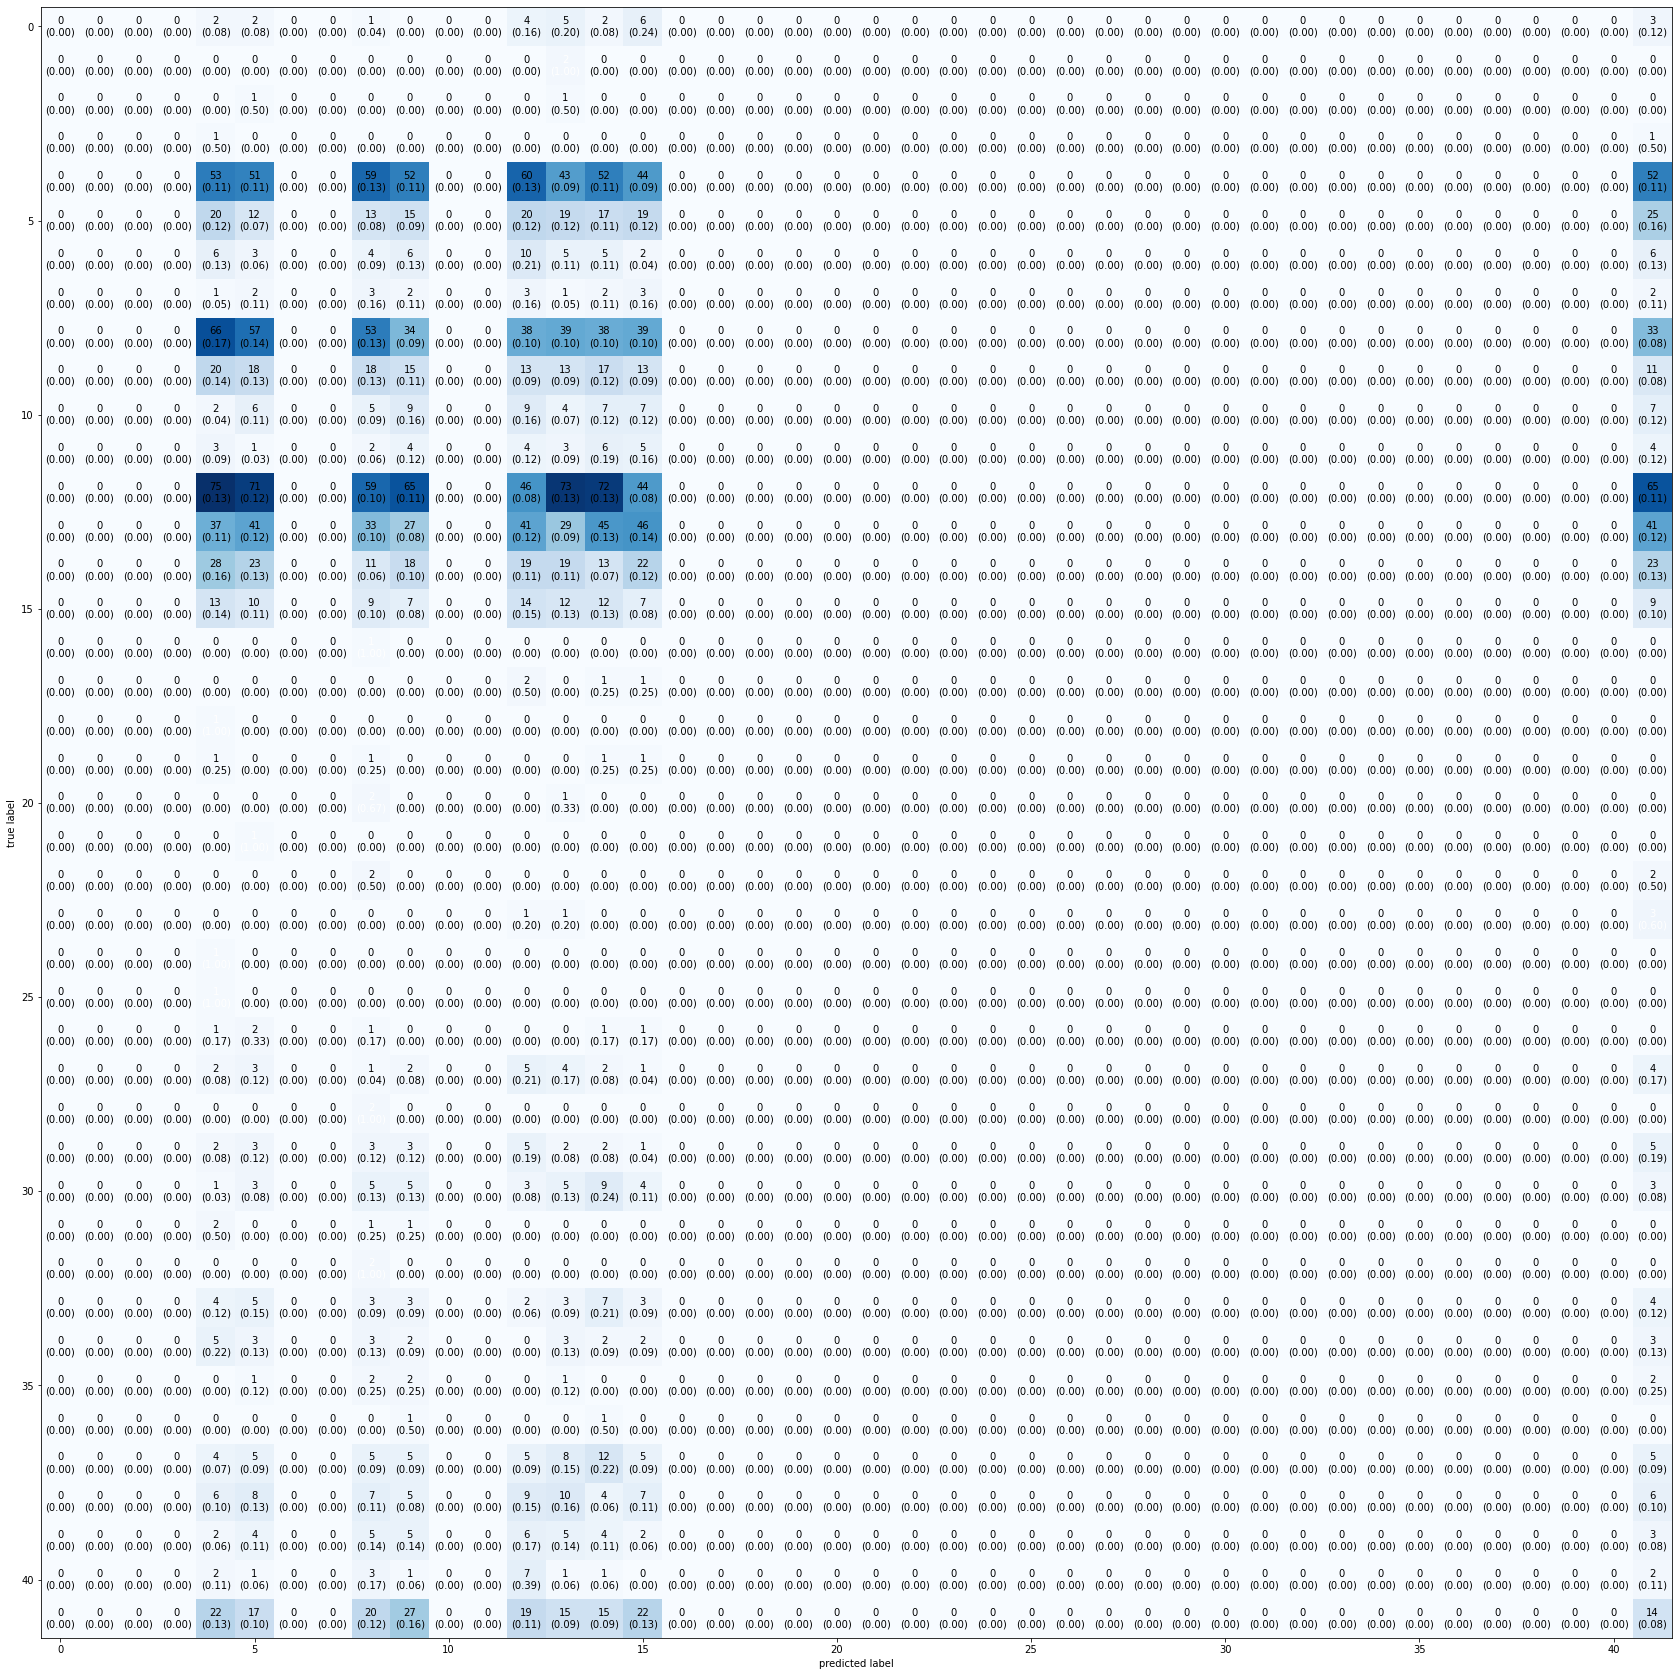

In [ ]:
# plot_confusion_matrix(conf_mat=mat_classifier_finalstate, figsize=(20,20), class_name=FinalState(enum.Enum))
plot_confusion_matrix(conf_mat=mat_classifier_finalstate, figsize=(30,30), show_normed=True)

The model had 28 552 parameters in total, 28 424 of which were trainable.

The training was done on a batch of 100 during four epochs -- see Discussion for more information.

The loss was 3.8953. The accuracy was 0.1520.

Due to the size of the confusion matrix ($41\times41$), the readers are encouraged to see the full document in Appendix 1.

Over-fitting was not the case for the validation data.

## Energy predictor (3.4.2)

### Data import

In [ ]:
training_lepton, testing_lepton, label_training_lepton, label_testing_lepton= train_test_split(big_df,a[2],test_size=0.2)
testing_lepton, validation_lepton, label_testing_lepton, label_validation_lepton = train_test_split(testing_lepton, label_testing_lepton,test_size=0.45)

In [ ]:
training_neutrino, testing_neutrino, label_training_neutrino, label_testing_neutrino= train_test_split(big_df,a[3],test_size=0.2)
testing_neutrino, validation_neutrino, label_testing_neutrino, label_validation_neutrino = train_test_split(testing_neutrino, label_testing_neutrino,test_size=0.45)

In [ ]:
training_lepton=training_lepton.reshape(2,-1,100,80)
testing_lepton=testing_lepton.reshape(2,-1,100,80)
validation_lepton=validation_lepton.reshape(2,-1,100,80)

In [ ]:
training_neutrino=training_neutrino.reshape(2,-1,100,80)
testing_neutrino=testing_neutrino.reshape(2,-1,100,80)
validation_neutrino=validation_neutrino.reshape(2,-1,100,80)

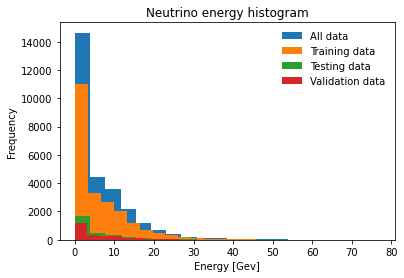

In [ ]:
# histogram of neutrino energy values
plt.hist(a[3], bins=20, label = 'All data')
plt.hist(label_training_neutrino, bins=20, label = 'Training data')
plt.hist(label_testing_neutrino, bins=20, label = 'Testing data')
plt.hist(label_validation_neutrino, bins=20, label = 'Validation data')

plt.title('Neutrino energy histogram')
plt.xlabel('Energy [Gev]')
plt.ylabel('Frequency')
plt.legend()

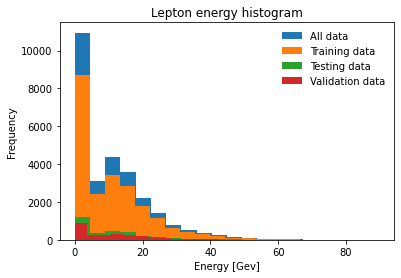

In [ ]:
# histogram of lepton energy values
plt.hist(a[2], bins=20, label = 'All data')
plt.hist(label_training_lepton, bins=20, label = 'Training data')
plt.hist(label_testing_lepton, bins=20, label = 'Testing data')
plt.hist(label_validation_lepton, bins=20, label = 'Validation data')

plt.title('Lepton energy histogram')
plt.xlabel('Energy [Gev]')
plt.ylabel('Frequency')
plt.legend()

### Neural network

In [ ]:
def branch_bottlenecking(input_img):
    # detection of the underlying patterns through convolution layers
    x_view_1=keras.layers.Conv2D(16, (4, 4), activation='relu', strides=2, input_shape=(100,80,1))(input_img)
    x_view_2=keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_1)
    x_view_3=BatchNormalization()(x_view_2)
    x_view_4=keras.layers.Conv2D(16, (4, 4), activation='relu', strides=2, input_shape=(100,80,1))(x_view_3)
    x_view_5=keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_4)
    x_view_6=BatchNormalization()(x_view_5)

    #bottlenecking
    x_view_7=keras.layers.Conv2D(3,3,activation="relu",padding='same')(x_view_6)   # down
    x_view_8=keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_6)
    x_view_9=keras.layers.Dropout(0.2)(x_view_8)                                    # a dropout layer to eliminate overfocusing on some features of the training dataset
    x_view_10=keras.layers.Conv2D(3,3,activation="relu",padding='same')(x_view_9)  # down
    x_view_11=keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_10)
    x_view_12=keras.layers.UpSampling2D(size=(1,1))(x_view_11)                      # up
    x_view_13=keras.layers.Conv2D(3,3,activation="relu",padding='same')(x_view_12)
    x_view_14=keras.layers.UpSampling2D(size=(9,9))(x_view_13)                      # up
    x_view_15=keras.layers.Conv2D(3,3,activation="relu",padding='same')(x_view_14)
    
    # dense layers
    x_view_16=keras.layers.Dropout(0.2)(x_view_15)
    x_view_17=keras.layers.Flatten()(x_view_16)
    x_view_18=keras.layers.Dense(32, activation='relu')(x_view_17)
    return keras.layers.Dense(16, activation='relu')(x_view_18)

In [ ]:
#These need to be passed into the neural network for the compilation. Notice that the shapes matc those of the considered data.
input_img_1 = Input(shape=(100, 80, 1))
input_img_2 = Input(shape=(100, 80, 1))

In [ ]:
combined=concatenate([branch_bottlenecking(input_img_1),branch_bottlenecking(input_img_2)], axis=-1)
final=keras.layers.Dense(1, activation='linear')(combined)

In [ ]:
energy_predictor= Model(inputs=[input_img_1,input_img_2], outputs=[final])
energy_predictor.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam', metrics=['mean_squared_error'])

In [ ]:
energy_predictor.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, 100, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 49, 39, 16)   272         ['input_1[0][0]']                
                                                                                              

### Training

In [ ]:
with tf.device("/cpu:0"):    # Ran out of gpu memory so use cpu
    history_energy_predictor=energy_predictor.fit([training_lepton[0],training_lepton[1]], label_training_lepton, batch_size=100, epochs=5, validation_data=([validation_lepton[0],validation_lepton[1]], label_validation_lepton))

Epoch 1/5
223/223 [==============================] - 38s 165ms/step - loss: 114.8113 - mean_squared_error: 114.8113 - val_loss: 119.1629 - val_mean_squared_error: 119.1629
Epoch 2/5
223/223 [==============================] - 35s 158ms/step - loss: 113.1778 - mean_squared_error: 113.1778 - val_loss: 118.7922 - val_mean_squared_error: 118.7922
Epoch 3/5
223/223 [==============================] - 35s 159ms/step - loss: 112.8387 - mean_squared_error: 112.8387 - val_loss: 116.9969 - val_mean_squared_error: 116.9969
Epoch 4/5
223/223 [==============================] - 36s 159ms/step - loss: 112.7775 - mean_squared_error: 112.7775 - val_loss: 117.3742 - val_mean_squared_error: 117.3742
Epoch 5/5
223/223 [==============================] - 36s 160ms/step - loss: 112.2463 - mean_squared_error: 112.2463 - val_loss: 121.7775 - val_mean_squared_error: 121.7775


### Results

In [ ]:
test_loss_energy_predictor, test_acc_energy_predictor = energy_predictor.evaluate([testing_lepton[0],testing_lepton[1]], label_testing_lepton, verbose=2)

96/96 - 2s - loss: 117.9006 - mean_squared_error: 117.9006 - 2s/epoch - 22ms/step


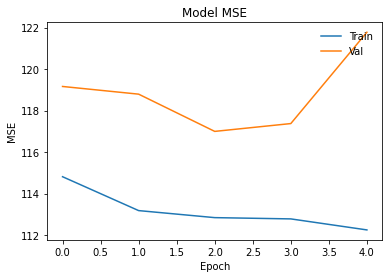

In [ ]:
plt.plot(history_energy_predictor.history['mean_squared_error'])
plt.plot(history_energy_predictor.history['val_mean_squared_error'])
plt.title("Model MSE")
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.legend(["Train","Val"], loc="upper right")
plt.show()

In [ ]:
with tf.device("/cpu:0"): # gpu ram limit used cpu
    predictions = energy_predictor.predict([testing_lepton[0],testing_lepton[1]])

In [ ]:
act_pred_error_lepton = label_testing_lepton - predictions.flatten() 

Text(0, 0.5, 'Frequency')

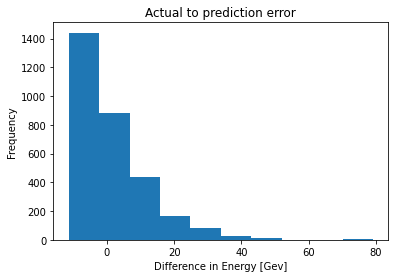

In [ ]:
plt.hist(act_pred_error_lepton, bins = 10)

plt.title('Actual to prediction error')
plt.xlabel('Difference in Energy [Gev]')
plt.ylabel('Frequency')

This section contains the results for the lepton data. Readers are encouraged to try the model for the neutrino data.

The majority of energies were less than 20 GeV, which shows the appropriate histogram.

The model had 26 935 parameters in total, 26 807 of which were trainable.

The training was done on a batch of 100 during five epochs. The RAM limit made it impossible to run the model without the support from the local CPU.

The loss was 117.9006. The accuracy was also 117.9006.

A useful tool to complement the accuracy given by the root mean square measure of the model is histogram of errors. It indicates if the errors are skewed, which can be used to judge the overestimation.

Over-fitting was not the case for the validation data.

# Metadata analysis (3.5)

The section is to assess how the accuracy of prediction changes when the metadata is changed. Several models have been presented, so this section will be limited to the initial $\nu_{\mu}$-classifier.

The main task in this section is to adequately prepare data for testing. The rest is a straightforward comaprison of the performances. Due to the RAM limitations, some tests and training had to be done after resstarting kernels, so all the results are given in relative terms. 

As explained in the report, this section focuses on assessing the performance of the $\nu_{\mu}$-classifier with respect to the metadata. The same procedures could be applied for the other algorithms described in this notebook. 

## Data preparation

### Binary classifier

The following identifies the indices corresponding to "one"s and "zero"s

In [ ]:
indexes_zeros=np.where(label_testing==0)
indexes_ones=np.where(label_testing==1)

#  This can be printed to check the shapes
print(indexes_zeros[0].shape,indexes_ones[0].shape)

(331,) (2729,)


Two new sets are created by removing "zero"s and "one"s from the testing set.

In [ ]:
testing_ones=np.delete(testing, indexes_zeros, axis=1)
testing_zeros=np.delete(testing, indexes_ones, axis=1)
print(testing_zeros.shape,testing_ones.shape)

(2, 331, 100, 80) (2, 2729, 100, 80)


And likewise for labels:

In [ ]:
label_testing_ones=np.delete(label_testing, indexes_zeros, axis=0)
label_testing_zeros=np.delete(label_testing, indexes_ones, axis=0)
print(label_testing_zeros.shape,label_testing_ones.shape)

(331,) (2729,)


### Energies

Energies are real numbers, so a classification into four ranges was chosen to organise data. The rest of the scheme is analogical to that for the binary classifier, with a duly noted exception of the source of data. In the previous section, it was taken from the training dataset. This time it had to be processed directly from the imported data (to differentiate for the parameters that the binary classifier is not shown).

In [ ]:
indexes_energies_lepton_0_10=np.where(a[2]<10)[0]                                                                 #find leptons of energies less than 10 GeV

indexes_energies_lepton_10_20=np.where(a[2]<20)[0]                                                                #find leptons of energies less than 20 GeV
indexes_energies_lepton_10_20=np.setdiff1d(indexes_energies_lepton_10_20,indexes_energies_lepton_0_10)            #use the indices for leptons of energies less than 10 GeV to get those in range [10,20)

indexes_energies_lepton_20_30=np.where(a[2]<30)[0]                                                                #likewise
indexes_energies_lepton_20_30=np.setdiff1d(indexes_energies_lepton_20_30,indexes_energies_lepton_0_10)
indexes_energies_lepton_20_30=np.setdiff1d(indexes_energies_lepton_20_30,indexes_energies_lepton_10_20)

indexes_energies_lepton_30_more=np.where(a[2]>30)[0]                                                              #find the remaining leptons

#  This can be printed to check the shapes
print(a[2].shape, indexes_energies_lepton_0_10.shape, indexes_energies_lepton_10_20.shape, indexes_energies_lepton_20_30.shape, indexes_energies_lepton_30_more.shape)

(27820,) (14845,) (8199,) (3099,) (1677,)


Analogically,

In [ ]:
indexes_energies_neutrino_0_10=np.where(a[3]<10)[0]

indexes_energies_neutrino_10_20=np.where(a[3]<20)[0]
indexes_energies_neutrino_10_20=np.setdiff1d(indexes_energies_neutrino_10_20,indexes_energies_neutrino_0_10)

indexes_energies_neutrino_20_30=np.where(a[3]<30)[0]
indexes_energies_neutrino_20_30=np.setdiff1d(indexes_energies_neutrino_20_30,indexes_energies_neutrino_0_10)
indexes_energies_neutrino_20_30=np.setdiff1d(indexes_energies_neutrino_20_30,indexes_energies_neutrino_10_20)

indexes_energies_neutrino_30_more=np.where(a[3]>30)[0]

#  This can be printed to check the shapes
print(a[3].shape, indexes_energies_neutrino_0_10.shape, indexes_energies_neutrino_10_20.shape, indexes_energies_neutrino_20_30.shape, indexes_energies_neutrino_30_more.shape)

(27820,) (21390,) (4796,) (1153,) (481,)


Due to RAM limitations, the following operations were split into different cells, but a more computionally efficient PC could do it at once.

In [ ]:
#Lepton energies in [0,10)
indexes_to_throw_out=np.hstack((indexes_energies_lepton_10_20,indexes_energies_lepton_20_30,indexes_energies_lepton_30_more )).ravel() #identify the list of indices that whose corresponding energies do not pertain to the range
label_energies_lepton_0_10=np.delete(a[1], indexes_to_throw_out, axis=0)                                                               #remove unwanted labels
energies_lepton_0_10=np.delete(big_df, indexes_to_throw_out, axis=0)                                                                   #likewise, pictures
energies_lepton_0_10=energies_lepton_0_10.reshape(2,-1,100,80)                                                                         #reshape in the standard way as before

In [ ]:
#Lepton energies in [10,20)
indexes_to_throw_out=np.hstack((indexes_energies_lepton_0_10,indexes_energies_lepton_20_30,indexes_energies_lepton_30_more )).ravel()
label_energies_lepton_10_20=np.delete(a[1], indexes_to_throw_out, axis=0)
energies_lepton_10_20=np.delete(big_df, indexes_to_throw_out, axis=0)
energies_lepton_10_20=energies_lepton_10_20.reshape(2,-1,100,80)

In [ ]:
#Lepton energies in [20,30)
indexes_to_throw_out=np.hstack((indexes_energies_lepton_0_10,indexes_energies_lepton_10_20,indexes_energies_lepton_30_more )).ravel()
label_energies_lepton_20_30=np.delete(a[1], indexes_to_throw_out, axis=0)
energies_lepton_20_30=np.delete(big_df, indexes_to_throw_out, axis=0)
energies_lepton_20_30=energies_lepton_20_30.reshape(2,-1,100,80)

In [ ]:
#Lepton energies more than 30
indexes_to_throw_out=np.hstack((indexes_energies_lepton_0_10,indexes_energies_lepton_10_20,indexes_energies_lepton_20_30 )).ravel()
label_energies_lepton_30_more=np.delete(a[1], indexes_to_throw_out, axis=0)
energies_lepton_30_more=np.delete(big_df, indexes_to_throw_out, axis=0)
energies_lepton_30_more=energies_lepton_30_more.reshape(2,-1,100,80)

In [ ]:
print(energies_lepton_0_10.shape,energies_lepton_10_20.shape,energies_lepton_20_30.shape,energies_lepton_30_more.shape)
print(label_energies_lepton_0_10.shape,label_energies_lepton_10_20.shape,label_energies_lepton_20_30.shape,label_energies_lepton_30_more.shape)

(2, 14845, 100, 80) (2, 8199, 100, 80) (2, 3099, 100, 80) (2, 1677, 100, 80)
(14845,) (8199,) (3099,) (1677,)


In [ ]:
#Neutrino energies in [0,10)
with tf.device("/cpu:0"):
    indexes_to_throw_out=np.hstack((indexes_energies_neutrino_10_20,indexes_energies_neutrino_20_30,indexes_energies_neutrino_30_more )).ravel()
    label_energies_neutrino_0_10=np.delete(a[1], indexes_to_throw_out, axis=0)
    energies_neutrino_0_10=np.delete(big_df, indexes_to_throw_out, axis=0)
    energies_neutrino_0_10=energies_neutrino_0_10.reshape(2,-1,100,80)

In [ ]:
#Neutrino energies in [10,20)
indexes_to_throw_out=np.hstack((indexes_energies_neutrino_0_10,indexes_energies_neutrino_20_30,indexes_energies_neutrino_30_more )).ravel()
label_energies_neutrino_10_20=np.delete(a[1], indexes_to_throw_out, axis=0)
energies_neutrino_10_20=np.delete(big_df, indexes_to_throw_out, axis=0)
energies_neutrino_10_20=energies_neutrino_10_20.reshape(2,-1,100,80)

In [ ]:
#Neutrino energies in [20,30)
indexes_to_throw_out=np.hstack((indexes_energies_neutrino_0_10,indexes_energies_neutrino_10_20,indexes_energies_neutrino_30_more )).ravel()
label_energies_neutrino_20_30=np.delete(a[1], indexes_to_throw_out, axis=0)
energies_neutrino_20_30=np.delete(big_df, indexes_to_throw_out, axis=0)
energies_neutrino_20_30=energies_neutrino_20_30.reshape(2,-1,100,80)

In [ ]:
#Neutrino energies more than 30
indexes_to_throw_out=np.hstack((indexes_energies_neutrino_0_10,indexes_energies_neutrino_10_20,indexes_energies_neutrino_20_30 )).ravel()
label_energies_neutrino_30_more=np.delete(a[1], indexes_to_throw_out, axis=0)
energies_neutrino_30_more=np.delete(big_df, indexes_to_throw_out, axis=0)
energies_neutrino_30_more=energies_neutrino_30_more.reshape(2,-1,100,80)

In [ ]:
print(energies_neutrino_0_10.shape,energies_neutrino_10_20.shape,energies_neutrino_20_30.shape,energies_neutrino_30_more.shape)
print(label_energies_neutrino_0_10.shape,label_energies_neutrino_10_20.shape,label_energies_neutrino_20_30.shape,label_energies_neutrino_30_more.shape)

### Final state

In [ ]:
finalstate_max=int(max(a[0]))

for i in range(finalstate_max):
    name="indexes_"+str(i)
    print(name)
    print(np.where(a[0]==i)[0])
    globals()[name]=np.where(a[0]==i)[0]
    print(name)

# print(indexes_1)

indexes_0
[  138   350   460   536  1095  1126  1401  1743  1764  2126  2164  2408
  2654  2683  2787  3054  3273  3310  3434  3526  3650  4071  4433  4911
  5094  5102  5219  5249  5288  5749  5924  6428  6486  6703  6944  6955
  6984  7463  7657  7746  7778  7805  8162  8198  8246  8257  8317  8537
  8732  8793  8867  8924  9180  9297  9482  9794  9838 10348 10546 10729
 10810 10912 10936 11040 11077 11333 11731 11757 11800 11880 12041 12074
 12222 12504 12584 12804 12906 13214 13540 13788 13863 13897 14580 14769
 15212 15229 15574 15789 15791 16342 16346 16438 16531 16676 16729 17134
 17371 17503 17580 17592 17644 18558 18561 18696 18730 18942 19023 19219
 19262 19420 20124 20196 20246 20726 20746 20770 20879 20994 21019 21276
 21348 21394 21425 21856 21902 21934 21975 21991 22684 22706 22711 22752
 22876 23007 23060 23175 23290 23555 23950 24177 24254 24316 24662 24984
 25134 25469 25575 25587 25636 25688 25791 26436 26494 26629 26685 26985
 27018 27518 27531 27888 27982 28681 2892

## Neural network and testing

### Network

In [5]:
def branch(input_img):
    x_view_1=keras.layers.Conv2D(16, (4, 4), activation='relu', strides=2, input_shape=(100,80,1))(input_img)
    x_view_2=keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_1)
    x_view_3=BatchNormalization()(x_view_2)
    x_view_4=keras.layers.Conv2D(16, (4, 4), activation='relu', strides=2, input_shape=(100,80,1))(x_view_3)
    x_view_5=keras.layers.MaxPooling2D((3, 3),padding='same')(x_view_4)
    x_view_6=BatchNormalization()(x_view_5)
    x_view_7=keras.layers.Dropout(0.2)(x_view_6)
    x_view_8=keras.layers.Flatten()(x_view_7)
    x_view_9=keras.layers.Dense(32, activation='relu')(x_view_8)
    return keras.layers.Dense(16, activation='relu')(x_view_9)

In [6]:
#These need to be passed into the neural network for the compilation. Notice that the shapes matc those of the considered data.
input_img_1 = Input(shape=(100, 80, 1))
input_img_2 = Input(shape=(100, 80, 1))

In [7]:
combined=concatenate([branch(input_img_1),branch(input_img_2)], axis=-1)
final=keras.layers.Dense(2, activation='sigmoid')(combined)
final_2=tf.keras.layers.Softmax(axis=-1)(final)

In [8]:
classifier= Model(inputs=[input_img_1,input_img_2], outputs=[final_2])
classifier.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])

### NC vs CC

This shows how the analysis was done. First, the network was trained.

In [ ]:
history_classifier=classifier.fit([training[0],training[1]], label_training, batch_size=100, epochs=2, validation_data=([validation[0],validation[1]], label_validation))

Epoch 1/2
223/223 [==============================] - 35s 152ms/step - loss: 0.6934 - accuracy: 0.4516 - val_loss: 0.6931 - val_accuracy: 0.1565
Epoch 2/2
223/223 [==============================] - 35s 157ms/step - loss: 0.6932 - accuracy: 0.4394 - val_loss: 0.6932 - val_accuracy: 0.3219


Secondly, testing was done for all the data.

In [ ]:
test_loss_classifier, test_acc_classifier = classifier.evaluate([testing[0],testing[1]], label_testing, verbose=2)

96/96 - 2s - loss: 0.6932 - accuracy: 0.3046 - 2s/epoch - 18ms/step


Finally, testing for just a subset of data was done.

In [ ]:
test_loss_classifier, test_acc_classifier = classifier.evaluate([testing_zeros[0],testing_zeros[1]], label_testing_zeros, verbose=2)

11/11 - 0s - loss: 0.6932 - accuracy: 0.7432 - 236ms/epoch - 21ms/step


In [ ]:
test_loss_classifier, test_acc_classifier = classifier.evaluate([testing_ones[0],testing_ones[1]], label_testing_ones, verbose=2)

86/86 - 1s - loss: 0.6932 - accuracy: 0.2514 - 1s/epoch - 17ms/step


### Energies of leptons

#### $E\in[0,10)$ GeV

In [ ]:
with tf.device("/cpu:0"):
    history_classifier=classifier.fit([training[0],training[1]], label_training, batch_size=100, epochs=2, validation_data=([validation[0],validation[1]], label_validation))

Epoch 1/2
223/223 [==============================] - 26s 113ms/step - loss: 0.6940 - accuracy: 0.4928 - val_loss: 0.6931 - val_accuracy: 0.8267
Epoch 2/2
223/223 [==============================] - 25s 112ms/step - loss: 0.6932 - accuracy: 0.4871 - val_loss: 0.6932 - val_accuracy: 0.6558


In [ ]:
test_loss_classifier, test_acc_classifier = classifier.evaluate([testing[0],testing[1]], label_testing, verbose=2)

96/96 - 2s - loss: 0.6931 - accuracy: 0.4245 - 2s/epoch - 17ms/step


In [ ]:
with tf.device("/cpu:0"):
    test_loss_classifier, test_acc_classifier = classifier.evaluate([energies_lepton_0_10[0],energies_lepton_0_10[1]], label_energies_lepton_0_10, verbose=2)

464/464 - 8s - loss: 0.6931 - accuracy: 0.4412 - 8s/epoch - 17ms/step


#### $E\in[10,20)$ GeV

In [ ]:
with tf.device("/cpu:0"):
    history_classifier=classifier.fit([training[0],training[1]], label_training, batch_size=100, epochs=2, validation_data=([validation[0],validation[1]], label_validation))

In [ ]:
test_loss_classifier, test_acc_classifier = classifier.evaluate([testing[0],testing[1]], label_testing, verbose=2)

96/96 - 2s - loss: 0.6932 - accuracy: 0.5624 - 2s/epoch - 17ms/step


In [ ]:
test_loss_classifier, test_acc_classifier = classifier.evaluate([energies_lepton_10_20[0],energies_lepton_10_20[1]], label_energies_lepton_10_20, verbose=2)

257/257 - 4s - loss: 0.6932 - accuracy: 0.5503 - 4s/epoch - 17ms/step


#### $E\in[20,30)$ GeV

In [ ]:
with tf.device("/cpu:0"):
    history_classifier=classifier.fit([training[0],training[1]], label_training, batch_size=100, epochs=2, validation_data=([validation[0],validation[1]], label_validation))

Epoch 1/2
223/223 [==============================] - 35s 149ms/step - loss: 0.6934 - accuracy: 0.4952 - val_loss: 0.6931 - val_accuracy: 0.8526
Epoch 2/2
223/223 [==============================] - 33s 147ms/step - loss: 0.6932 - accuracy: 0.4778 - val_loss: 0.6931 - val_accuracy: 0.4221


In [ ]:
test_loss_classifier, test_acc_classifier = classifier.evaluate([testing[0],testing[1]], label_testing, verbose=2)

96/96 - 2s - loss: 0.6931 - accuracy: 0.4245 - 2s/epoch - 17ms/step


In [ ]:
test_loss_classifier, test_acc_classifier = classifier.evaluate([energies_lepton_20_30[0],energies_lepton_20_30[1]], label_energies_lepton_20_30, verbose=2)

97/97 - 2s - loss: 0.6932 - accuracy: 0.5263 - 2s/epoch - 17ms/step


#### $E\in[30,∞)$ GeV

In [ ]:
with tf.device("/cpu:0"):
    history_classifier=classifier.fit([training[0],training[1]], label_training, batch_size=100, epochs=2, validation_data=([validation[0],validation[1]], label_validation))

Epoch 1/2
223/223 [==============================] - 35s 149ms/step - loss: 0.6934 - accuracy: 0.4952 - val_loss: 0.6931 - val_accuracy: 0.8526
Epoch 2/2
223/223 [==============================] - 33s 147ms/step - loss: 0.6932 - accuracy: 0.4778 - val_loss: 0.6931 - val_accuracy: 0.4221


In [ ]:
test_loss_classifier, test_acc_classifier = classifier.evaluate([testing[0],testing[1]], label_testing, verbose=2)

96/96 - 2s - loss: 0.6931 - accuracy: 0.4245 - 2s/epoch - 17ms/step


In [ ]:
test_loss_classifier, test_acc_classifier = classifier.evaluate([energies_lepton_30_more[0],energies_lepton_30_more[1]], label_energies_lepton_30_more, verbose=2)

53/53 - 1s - loss: 0.6932 - accuracy: 0.4800 - 883ms/epoch - 17ms/step


### Energies of neutrinos

#### $E\in[0,10)$ GeV

Readers are encouraged to perform this comaprison on their PCs, as Google Colab was incapable of performing this comparison due to the RAM limitations.

In [ ]:
history_classifier=classifier.fit([training[0],training[1]], label_training, batch_size=100, epochs=2, validation_data=([validation[0],validation[1]], label_validation))

Epoch 1/2
223/223 [==============================] - 34s 149ms/step - loss: 0.6933 - accuracy: 0.5465 - val_loss: 0.6931 - val_accuracy: 0.2424
Epoch 2/2
223/223 [==============================] - 33s 147ms/step - loss: 0.6931 - accuracy: 0.5483 - val_loss: 0.6932 - val_accuracy: 0.3922


In [ ]:
test_loss_classifier, test_acc_classifier = classifier.evaluate([testing[0],testing[1]], label_testing, verbose=2)

96/96 - 2s - loss: 0.6932 - accuracy: 0.3948 - 2s/epoch - 17ms/step


In [ ]:
with tf.device("/cpu:0"):
    test_loss_classifier, test_acc_classifier = classifier.evaluate([energies_neutrino_0_10[0][:-10000],energies_neutrino_0_10[1][:-10000]], label_energies_neutrino_0_10[:-10000], verbose=2)

#### $E\in[10,20)$ GeV

In [ ]:
history_classifier=classifier.fit([training[0],training[1]], label_training, batch_size=100, epochs=2, validation_data=([validation[0],validation[1]], label_validation))

Epoch 1/2
223/223 [==============================] - 26s 111ms/step - loss: 0.6933 - accuracy: 0.4762 - val_loss: 0.6931 - val_accuracy: 0.1937
Epoch 2/2
223/223 [==============================] - 25s 110ms/step - loss: 0.6931 - accuracy: 0.4739 - val_loss: 0.6932 - val_accuracy: 0.2772


In [ ]:
test_loss_classifier, test_acc_classifier = classifier.evaluate([testing[0],testing[1]], label_testing, verbose=2)

96/96 - 1s - loss: 0.6932 - accuracy: 0.2533 - 1s/epoch - 14ms/step


In [ ]:
test_loss_classifier, test_acc_classifier = classifier.evaluate([energies_neutrino_10_20[0],energies_neutrino_10_20[1]], label_energies_neutrino_10_20, verbose=2)

150/150 - 2s - loss: 0.6932 - accuracy: 0.2702 - 2s/epoch - 14ms/step


#### $E\in[20,30)$ GeV

In [ ]:
history_classifier=classifier.fit([training[0],training[1]], label_training, batch_size=100, epochs=2, validation_data=([validation[0],validation[1]], label_validation))

Epoch 1/2
223/223 [==============================] - 26s 111ms/step - loss: 0.6933 - accuracy: 0.4762 - val_loss: 0.6931 - val_accuracy: 0.1937
Epoch 2/2
223/223 [==============================] - 25s 110ms/step - loss: 0.6931 - accuracy: 0.4739 - val_loss: 0.6932 - val_accuracy: 0.2772


In [ ]:
test_loss_classifier, test_acc_classifier = classifier.evaluate([testing[0],testing[1]], label_testing, verbose=2)

96/96 - 1s - loss: 0.6932 - accuracy: 0.2533 - 1s/epoch - 14ms/step


In [ ]:
test_loss_classifier, test_acc_classifier = classifier.evaluate([energies_neutrino_20_30[0],energies_neutrino_20_30[1]], label_energies_neutrino_20_30, verbose=2)

37/37 - 1s - loss: 0.6932 - accuracy: 0.2697 - 519ms/epoch - 14ms/step


#### $E\in[30,∞)$ GeV

In [ ]:
history_classifier=classifier.fit([training[0],training[1]], label_training, batch_size=100, epochs=2, validation_data=([validation[0],validation[1]], label_validation))

Epoch 1/2
223/223 [==============================] - 26s 111ms/step - loss: 0.6933 - accuracy: 0.4762 - val_loss: 0.6931 - val_accuracy: 0.1937
Epoch 2/2
223/223 [==============================] - 25s 110ms/step - loss: 0.6931 - accuracy: 0.4739 - val_loss: 0.6932 - val_accuracy: 0.2772


In [ ]:
test_loss_classifier, test_acc_classifier = classifier.evaluate([testing[0],testing[1]], label_testing, verbose=2)

96/96 - 1s - loss: 0.6932 - accuracy: 0.2533 - 1s/epoch - 14ms/step


In [ ]:
test_loss_classifier, test_acc_classifier = classifier.evaluate([energies_neutrino_30_more[0],energies_neutrino_30_more[1]], label_energies_neutrino_30_more, verbose=2)

16/16 - 0s - loss: 0.6932 - accuracy: 0.2370 - 223ms/epoch - 14ms/step


### Interaction type

To investigate how well the classification was done depending on the interaction type, minor changes need to be included in the data import algorithm. The main difference is that labels store not only the "zero"/"one" label but also the type of interaction itself. Compare the changes below.

In [5]:
import urllib.request

def data_import_inter(start_file,end_file):
    # preallocate memory for the metadata parameters from all the pictures of interest
    big_finalstate=np.zeros(0)
    big_inter_boolean=np.zeros(0)
    big_nuenergy=np.zeros(0)
    big_lepenergy=np.zeros(0)
    big_inter=np.zeros(0)
    # create an array for the doublets of pictures from all the files of interest
    big_df=np.zeros([0,2,100,80])
    # put all the labels into a 2D array
    labels=np.zeros([0,4])
    
    for i in range(start_file,end_file,1): #loop over the files of interest
        # access the online repository of files
        url='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/nova/neutrino'+str(i)+'.h5'
        name="neutrino"+str(i)+".h5"
        urllib.request.urlretrieve(url, name)
        df=h5py.File(name,'r')

        # import all the metadata parameters 
        finalstate=df['neutrino']['finalstate'][:].T[0].astype(np.float32)  # transposition needed to make the data of the same format, as it was inside a higher-dimensional array than needed
                                                                            # the energy data is a float type and array labels needs to store the same type of data
        inter=np.array(df['neutrino']['interaction']).reshape(len(df['neutrino']['interaction'])).astype(np.float32) # similarly to the finalstate
        nuenergy=df['neutrino']['nuenergy'][:]
        lepenergy=df['neutrino']['lepenergy'][:].T[0] # as in the case of finalstate

        training_l=[finalstate,inter,nuenergy,lepenergy] # put all the labels from the currently processed file into one array

        # as the aim is to create a binary classifier, CC and NC events are assigned binary values
        training_labels_inter_boolean=training_l[1]<4
        training_labels_inter_boolean=training_labels_inter_boolean.astype(int) 

        flat_list = [item for sublist in training_l[2] for item in sublist] # the processing of nuenergy was deffered to here, as it required a differnt approach than other labels

        # join the infromation from the currently processed file with the others previously processed
        big_finalstate=np.concatenate([big_finalstate,finalstate]) 
        big_inter_boolean=np.concatenate([big_inter_boolean,training_labels_inter_boolean])
        big_nuenergy=np.concatenate([big_nuenergy, flat_list])
        big_lepenergy=np.concatenate([big_lepenergy, training_l[3]])
        big_inter=np.concatenate([big_inter,training_l[1]])                                                   #this is different, interaction labels also needed

        # join the doublets of pictures from the currently processed file with the other from the previously processed ones
        big_df=np.concatenate([big_df,np.array(df['cvnmap'][:]).reshape(-1,2,100,80)])
      
    # return the 2D array of labels and a 4D array of doublets of pictures  
    return np.array((big_finalstate,big_inter_boolean,big_nuenergy,big_lepenergy, big_inter)), big_df         #this is different, interaction labels also needed

In [6]:
# import the files of interest
a,big_df=data_import_inter(56,60)

See how the dimensions changed. The interaction type is now stored in a[4].

In [ ]:
print(a.shape)
print(big_df.shape)

(5, 27820)
(27820, 2, 100, 80)


Rescaling, splitting into the training/validation/testing datasets, and reshaping are as before.

In [7]:
big_df=big_df/np.amax(big_df.reshape(1,-1)) # find the maximum of the importet pixels, and divide the rest by this number. It is assumed that data is non-empty

In [8]:
training, testing, label_training, label_testing= train_test_split(big_df,a[1],test_size=0.2)
testing, validation, label_testing, label_validation = train_test_split(testing, label_testing,test_size=0.45)

# This can be printed to check the dimensions
# print(training.shape, testing.shape, label_training.shape, label_testing.shape)
# print(testing.shape, validation.shape, label_testing.shape, label_validation.shape)

In [9]:
training=training.reshape(2,-1,100,80)
validation=validation.reshape(2,-1,100,80)
testing=testing.reshape(2,-1,100,80)

# This can be preinted to check the shapes
# print(validation.shape)
# print(training.shape)
# print(testing.shape)

The following function is key to extract the data that is wanted. It reteruns pictures and labels of a chosen interaction type. 

In [10]:
def subdata(a,big_df,intera):
    interaction=np.where(a[4]==intera)[0]                 # look up which indecies correspond to the chosen interaction type
    all=np.arange(0,np.size(a[0]),1)                      # create an array matching the size of one dimension of a
    result=np.delete(all,interaction)                     # remove the indices corresponding to the interaction type from the set of all the indices
    labels_inter=np.delete(a,result,axis=1)               # two minuses give a plus! Remove the columns from "a" that do not correspond to the chosen interaction 
    pictures_inter=np.delete(big_df,result,axis=0)        # likewise for pictures
    pictures_inter=pictures_inter.reshape(2,-1,100,80)    # reshape pictures
    return labels_inter, pictures_inter

In [ ]:
# Example of how subdata(a,big_df,intera) works
labels_inter, pictures_inter = subdata(a,big_df,0)
print(labels_inter.shape, pictures_inter.shape)

(5, 3452) (2, 3452, 100, 80)


#### Interaction 0 and 1

Let the accuracies of prediction for all the labels be compared with the accuracies of prediction for the 0 and 1 interaction types. Only two could be checked at once due to the RAM limitations of Google Colab.

In [ ]:
history_classifier=classifier.fit([training[0],training[1]], label_training, batch_size=100, epochs=2, validation_data=([validation[0],validation[1]], label_validation))

Epoch 1/2
223/223 [==============================] - 35s 149ms/step - loss: 0.6937 - accuracy: 0.5057 - val_loss: 0.6931 - val_accuracy: 0.5140
Epoch 2/2
223/223 [==============================] - 33s 146ms/step - loss: 0.6932 - accuracy: 0.4966 - val_loss: 0.6931 - val_accuracy: 0.5124


In [ ]:
test_loss_classifier, test_acc_classifier = classifier.evaluate([testing[0],testing[1]], label_testing, verbose=2)

96/96 - 2s - loss: 0.6931 - accuracy: 0.5039 - 2s/epoch - 17ms/step


In [ ]:
for intera in range(13):
    labels_inter, pictures_inter = subdata(a,big_df,intera)
    print(intera)
    test_loss_classifier, test_acc_classifier = classifier.evaluate([pictures_inter[0],pictures_inter[1]], labels_inter[1], verbose=2)

0
108/108 - 2s - loss: 0.6931 - accuracy: 0.5698 - 2s/epoch - 17ms/step
1
165/165 - 3s - loss: 0.6931 - accuracy: 0.5385 - 3s/epoch - 17ms/step


#### Interaction 2-13

Likewise, let the accuracies for interactions 2-13 be compared to the reference accuracy on all the data.

In [ ]:
history_classifier=classifier.fit([training[0],training[1]], label_training, batch_size=100, epochs=2, validation_data=([validation[0],validation[1]], label_validation))

Epoch 1/2
223/223 [==============================] - 35s 152ms/step - loss: 0.6933 - accuracy: 0.4780 - val_loss: 0.6931 - val_accuracy: 0.8670
Epoch 2/2
223/223 [==============================] - 33s 149ms/step - loss: 0.6931 - accuracy: 0.4943 - val_loss: 0.6931 - val_accuracy: 0.7324


In [ ]:
test_loss_classifier, test_acc_classifier = classifier.evaluate([testing[0],testing[1]], label_testing, verbose=2)

96/96 - 2s - loss: 0.6931 - accuracy: 0.7467 - 2s/epoch - 17ms/step


In [ ]:
for intera in range(2,8,1):
    labels_inter, pictures_inter = subdata(a,big_df,intera)
    print(intera)
    test_loss_classifier, test_acc_classifier = classifier.evaluate([pictures_inter[0],pictures_inter[1]], labels_inter[1], verbose=2)

2
473/473 - 8s - loss: 0.6931 - accuracy: 0.7970 - 8s/epoch - 17ms/step
3
25/25 - 1s - loss: 0.6931 - accuracy: 0.9075 - 575ms/epoch - 23ms/step
4
1/1 - 0s - loss: 0.6931 - accuracy: 0.4737 - 28ms/epoch - 28ms/step
5
2/2 - 0s - loss: 0.6931 - accuracy: 0.4130 - 44ms/epoch - 22ms/step
6
9/9 - 0s - loss: 0.6931 - accuracy: 0.3434 - 169ms/epoch - 19ms/step
7
1/1 - 0s - loss: 0.6931 - accuracy: 0.8000 - 23ms/epoch - 23ms/step


Interactions 8 to 12 were not present in none of the training, validation, and testing datasets. Hence, the comaprison including them cannot be done.

In [ ]:
for intera in range (8,13):
    labels_inter, pictures_inter = subdata(a,big_df,intera)
    print(intera,labels_inter.shape, pictures_inter.shape)

8 (5, 0) (2, 0, 100, 80)
9 (5, 0) (2, 0, 100, 80)
10 (5, 0) (2, 0, 100, 80)
11 (5, 0) (2, 0, 100, 80)
12 (5, 0) (2, 0, 100, 80)


In [ ]:
labels_inter, pictures_inter = subdata(a,big_df,13)
print(13)
test_loss_classifier, test_acc_classifier = classifier.evaluate([pictures_inter[0],pictures_inter[1]], labels_inter[1], verbose=2)

13
83/83 - 1s - loss: 0.6931 - accuracy: 0.1962 - 1s/epoch - 18ms/step


#### Interaction 14-16

In [16]:
history_classifier=classifier.fit([training[0],training[1]], label_training, batch_size=100, epochs=2, validation_data=([validation[0],validation[1]], label_validation))

Epoch 1/2
223/223 [==============================] - 32s 138ms/step - loss: 0.6933 - accuracy: 0.4954 - val_loss: 0.6931 - val_accuracy: 0.4669
Epoch 2/2
223/223 [==============================] - 30s 136ms/step - loss: 0.6931 - accuracy: 0.5023 - val_loss: 0.6931 - val_accuracy: 0.8155


In [17]:
test_loss_classifier, test_acc_classifier = classifier.evaluate([testing[0],testing[1]], label_testing, verbose=2)

96/96 - 1s - loss: 0.6931 - accuracy: 0.7980 - 1s/epoch - 15ms/step


In [18]:
for intera in range (14,17):
    labels_inter, pictures_inter = subdata(a,big_df,intera)
    print(intera,labels_inter.shape, pictures_inter.shape)

14 (5, 0) (2, 0, 100, 80)
15 (5, 216) (2, 216, 100, 80)
16 (5, 0) (2, 0, 100, 80)


In [19]:
labels_inter, pictures_inter = subdata(a,big_df,15)
print(15)
test_loss_classifier, test_acc_classifier = classifier.evaluate([pictures_inter[0],pictures_inter[1]], labels_inter[1], verbose=2)

15
7/7 - 0s - loss: 0.6931 - accuracy: 0.0787 - 110ms/epoch - 16ms/step


### Final state

The classification of performance as for the final state will be analogical to the classification as per the interaction type. The subdata() function needs to be logically adjusted.

In [14]:
def subdata_final_state(a,big_df,final_state):
    interaction=np.where(a[0]==final_state)[0]                 # this is different
    all=np.arange(0,np.size(a[0]),1)
    result=np.delete(all,interaction)
    labels_inter=np.delete(a,result,axis=1)
    pictures_inter=np.delete(big_df,result,axis=0)
    pictures_inter=pictures_inter.reshape(2,-1,100,80)
    return labels_inter, pictures_inter

In [ ]:
#Example for a large number like 27
labels_final_state, pictures_final_state = subdata_final_state(a,big_df,27)
print(27,labels_final_state.shape, pictures_final_state.shape)

27 (5, 1) (2, 1, 100, 80)


The example of the final state 27 turned out to be not so representative (just one member). The following checks all the interactions.

In [19]:
history_classifier=classifier.fit([training[0],training[1]], label_training, batch_size=100, epochs=2, validation_data=([validation[0],validation[1]], label_validation))

Epoch 1/2
223/223 [==============================] - 34s 145ms/step - loss: 0.6936 - accuracy: 0.5134 - val_loss: 0.6932 - val_accuracy: 0.8742
Epoch 2/2
223/223 [==============================] - 32s 142ms/step - loss: 0.6932 - accuracy: 0.5209 - val_loss: 0.6931 - val_accuracy: 0.5675


In [20]:
test_loss_classifier, test_acc_classifier = classifier.evaluate([testing[0],testing[1]], label_testing, verbose=2)

96/96 - 2s - loss: 0.6931 - accuracy: 0.5395 - 2s/epoch - 16ms/step


In [35]:
for intera in range(0,int(max(a[0])+1),1):
    labels_inter, pictures_inter = subdata_final_state(a,big_df,intera)
    if np.size(labels_inter)!=0:
        print(intera)
        test_loss_classifier, test_acc_classifier = classifier.evaluate([pictures_inter[0],pictures_inter[1]], labels_inter[1], verbose=2)

0
5/5 - 0s - loss: 0.6931 - accuracy: 0.5283 - 97ms/epoch - 19ms/step
1
2/2 - 0s - loss: 0.6931 - accuracy: 0.4490 - 43ms/epoch - 22ms/step
2
1/1 - 0s - loss: 0.6932 - accuracy: 0.5882 - 26ms/epoch - 26ms/step
3
1/1 - 0s - loss: 0.6932 - accuracy: 0.2857 - 27ms/epoch - 27ms/step
4
130/130 - 2s - loss: 0.6931 - accuracy: 0.6131 - 2s/epoch - 16ms/step
5
50/50 - 1s - loss: 0.6931 - accuracy: 0.5511 - 817ms/epoch - 16ms/step
6
13/13 - 0s - loss: 0.6932 - accuracy: 0.6253 - 218ms/epoch - 17ms/step
7
6/6 - 0s - loss: 0.6932 - accuracy: 0.5607 - 107ms/epoch - 18ms/step
8
108/108 - 2s - loss: 0.6931 - accuracy: 0.5679 - 2s/epoch - 16ms/step
9
37/37 - 1s - loss: 0.6931 - accuracy: 0.5412 - 590ms/epoch - 16ms/step
10
14/14 - 0s - loss: 0.6932 - accuracy: 0.5465 - 252ms/epoch - 18ms/step
11
8/8 - 0s - loss: 0.6932 - accuracy: 0.6017 - 138ms/epoch - 17ms/step
12
172/172 - 3s - loss: 0.6931 - accuracy: 0.5625 - 3s/epoch - 15ms/step
13
107/107 - 2s - loss: 0.6932 - accuracy: 0.5603 - 2s/epoch - 15ms